In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import argparse
import pathlib
from tensorflow.keras import layers
import sys
import numpy as np
from sklearn.decomposition import IncrementalPCA
from scipy.stats import wasserstein_distance,energy_distance
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt

# Lista de Variables para Configuración Primer Epxilon

In [ ]:
## Lista de Parametros
Arq = 'vgg19'
Cap = 'dense'
Att = 'PGD'
Epx = '03'
Epx_val = 0.3
DS = 'mnist'

In [ ]:
def FGSM_GEN(model, image_in, target_label, epsilon,tiles=10):

  with tf.GradientTape() as tape:
    tape.watch(image_in)
    image= tf.expand_dims(image_in, axis=0)
    image = tf.tile(image, (tiles, 1, 1, 1))
    prediction = model(image)
    loss = tf.math.reduce_mean(nll(target_label, prediction))

  gradient = tape.gradient(loss, image_in)
  perturbation = epsilon * tf.sign(gradient)
  adversary = image_in + perturbation
  adversary = tf.clip_by_value(adversary, 0, 1)

  return adversary

## Ataque PGD
def pgd_attack(model, image, target_label, epsilon=0.15, num_steps=100, step_size=0.01):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy(from_logits=True)(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

## Ataque C&W
'''def pgd_attack(model, image, target_label, num_steps=500, step_size=0.0, epsilon=0.01):
    def loss_(image,target_label):
        image = tf.expand_dims(image, axis=0)
        image_tile = tf.tile(image, (5, 1, 1, 1))
        logits = model(image_tile)
        targets = tf.reduce_sum(logits * target_label, axis=1)
        others = tf.reduce_max(logits * (1 - target_label), axis=1)
        return tf.maximum(0.0, others - targets + step_size)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = tf.math.reduce_mean(loss_(image,target_label))

        gradient = tape.gradient(loss, image)
        image = image - epsilon * tf.sign(gradient)
        image = tf.clip_by_value(image, 0., 255.)

    return image'''
'''def pgd_attack_soft(model, image, target_label, epsilon=0.15, num_steps=1000, step_size=0.001):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy()(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image'''
def get_layer_dictionary(model_pret,input_shape=(32,32,1)):
  dict_models={}
  input=xvar=tf.keras.Input(input_shape)
  for idx,layer in enumerate(model_pret.layers):
    xvar=layer(xvar)
    dict_models[layer.name]=tf.keras.Model(input,xvar,name=layer.name)
    print(idx,layer.name)
  return dict_models

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32

## Ejemplo solo con la clase 0 para los de test-train

In [ ]:
from models.vgg_b1_Re import VGG as VGGb1r
from models.vgg_bt_Re import VGG as VGGbtr
vgg_b1r=VGGb1r(Arq,10)
vgg_btr=VGGbtr(Arq,10)

vgg_b1r.build((None,32,32,1))
vgg_b1r.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg19b1Re/mnist/checkpoint')
vgg_btr.build((None,32,32,1))
vgg_btr.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg19btRe/mnist/checkpoint')

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [ ]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)
    kl = sum(vgg_b1r.losses)
    return nll + kl / len_train
vgg_b1r.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss=nll,
                metrics=["accuracy"])

In [ ]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)
    kl = sum(vgg_btr.losses)
    return nll + kl / len_train
vgg_btr.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss=nll,
                metrics=["accuracy"])

# Verificar que los tres modelos estan correctamente cargados

# Victima 6

## Ataque 0

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 6
Vic_loc = 11
Cat = 0

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 5s 97ms/step - loss: 2860.4009 - accuracy: 0.9616


[2860.40087890625, 0.9615819454193115]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 4s 100ms/step - loss: 151.6936 - accuracy: 0.9977


[151.6935577392578, 0.9977400898933411]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


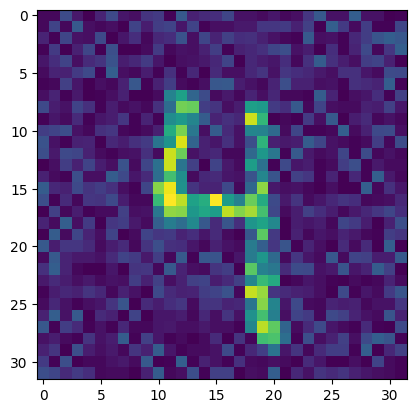

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.9019446427574718
distancia energia distribucion base y el ejemplo natural  0.7622227165444779


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.3620186053628798
distancia energia distribucion base y el ejemplo adversario  1.102634457074743


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-27-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-27-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

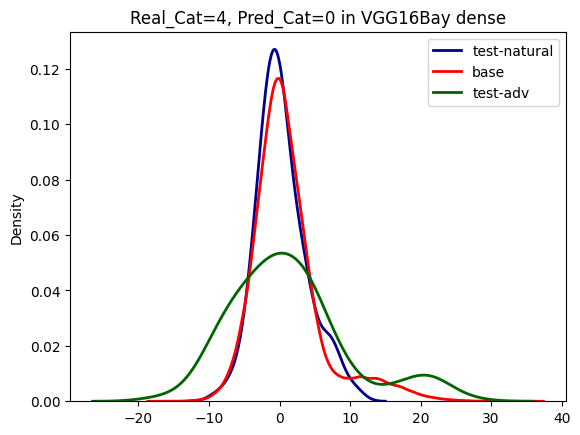

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


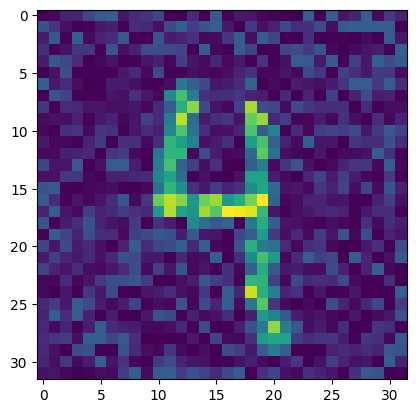

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.24000058464122
distancia energia distribucion base y el ejemplo natural  1.1416260077037115


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.396281765829965
distancia energia distribucion base y el ejemplo adversario  2.0842486796731494


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-42-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-42-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

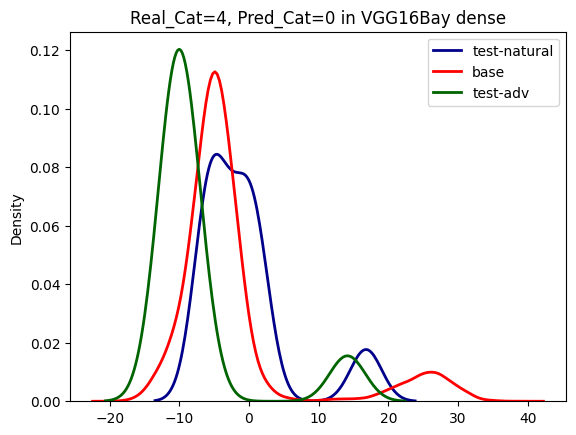

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 65ms/step - loss: 2860.3115 - accuracy: 0.9892


[2860.3115234375, 0.989226222038269]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 70ms/step - loss: 151.6862 - accuracy: 0.9951


[151.68624877929688, 0.9951028227806091]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


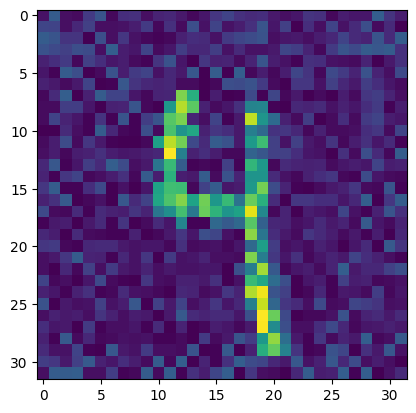

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.699505474422937
distancia energia distribucion base y el ejemplo natural  0.7790100762006025


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.9766043134961397
distancia energia distribucion base y el ejemplo adversario  1.2728007165882862


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-61-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-61-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

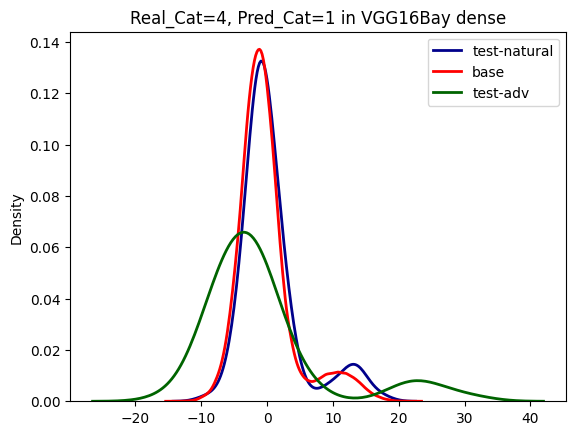

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


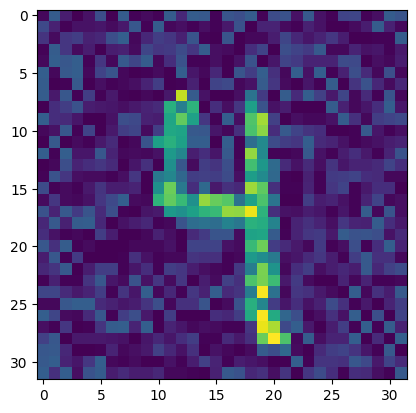

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.4316259538691734
distancia energia distribucion base y el ejemplo natural  0.6657431713528806


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.503451995225271
distancia energia distribucion base y el ejemplo adversario  2.718671850670155


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-76-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-76-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

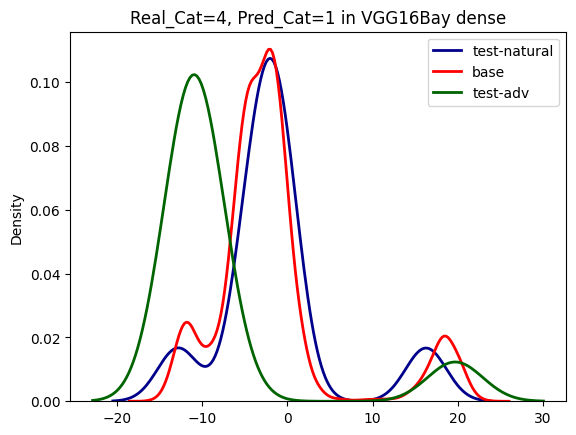

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 60ms/step - loss: 2860.4492 - accuracy: 0.9404


[2860.44921875, 0.9404255151748657]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 151.7342 - accuracy: 0.9872


[151.73423767089844, 0.9872340559959412]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


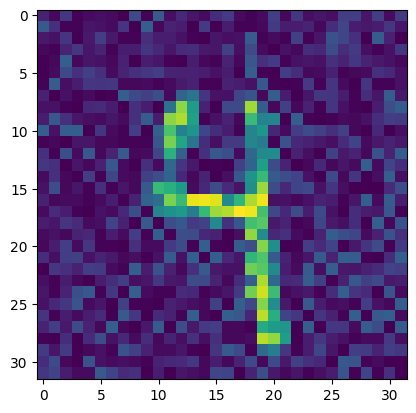

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3551058461072762
distancia energia distribucion base y el ejemplo natural  0.8920797387526526


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.7421798191548357
distancia energia distribucion base y el ejemplo adversario  1.1920908787768278


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-95-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-95-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

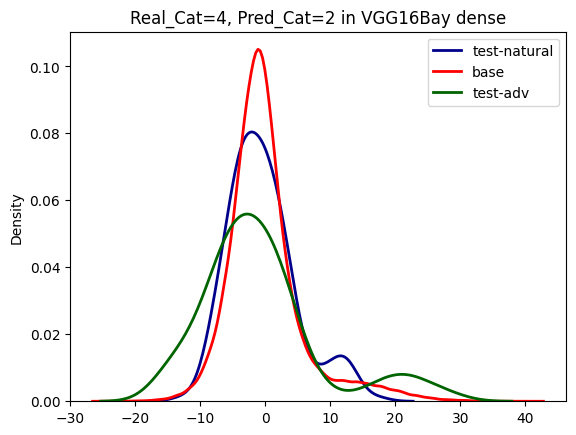

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


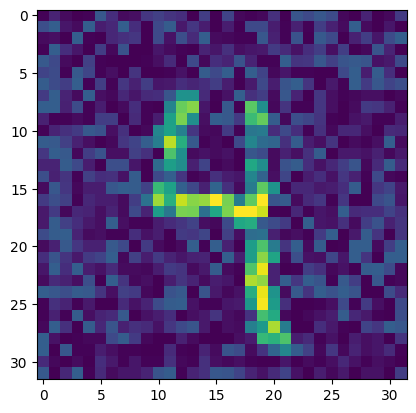

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.0950474044202907
distancia energia distribucion base y el ejemplo natural  0.8399156996931081


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.721213301503108
distancia energia distribucion base y el ejemplo adversario  2.946144146161238


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-110-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-110-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

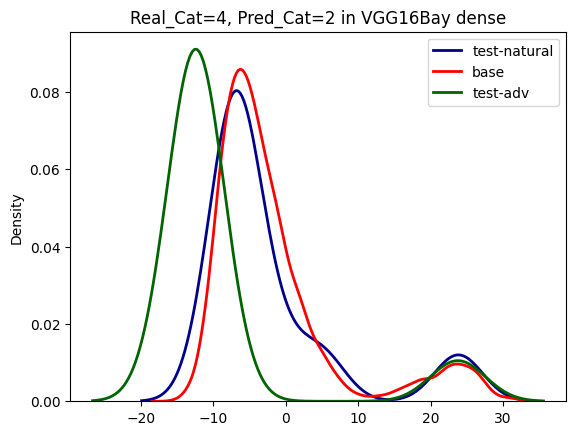

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 60ms/step - loss: 2860.3738 - accuracy: 0.9692


[2860.373779296875, 0.9691969156265259]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 59ms/step - loss: 151.6966 - accuracy: 0.9934


[151.69662475585938, 0.9933993220329285]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


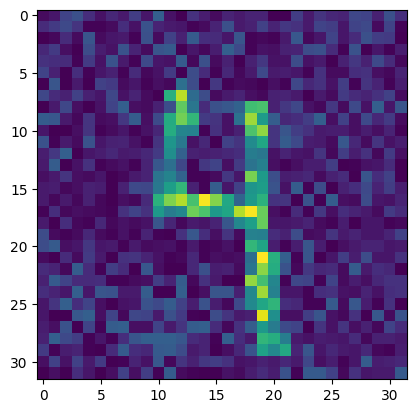

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.8600977400119536
distancia energia distribucion base y el ejemplo natural  0.7871183385951149


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.859726298563497
distancia energia distribucion base y el ejemplo adversario  1.211528587592023


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-129-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-129-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

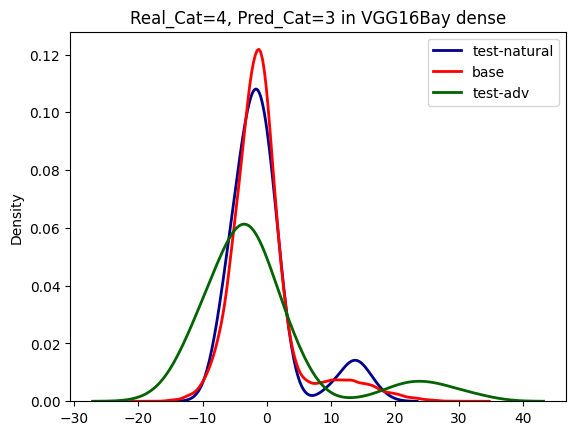

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


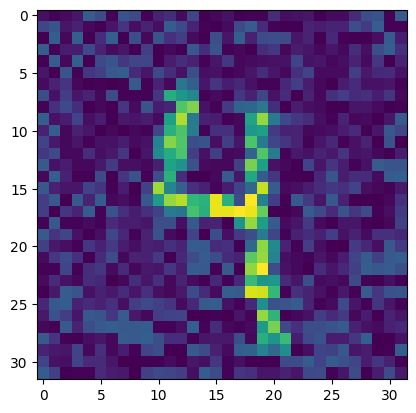

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.205671465181279
distancia energia distribucion base y el ejemplo natural  0.7410400741722329


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  9.750431021102425
distancia energia distribucion base y el ejemplo adversario  2.9067094154585065


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-144-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-144-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

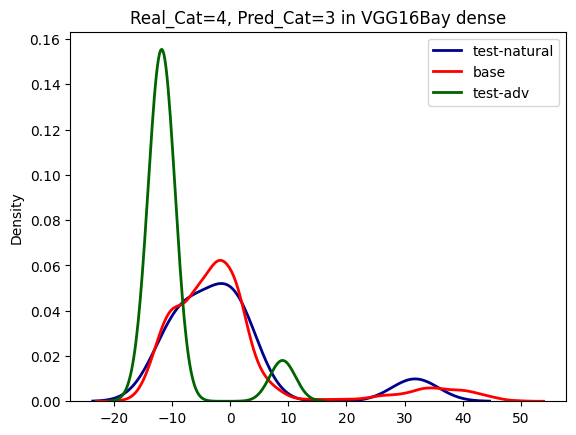

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 68ms/step - loss: 2860.4333 - accuracy: 0.9591


[2860.433349609375, 0.9591373205184937]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 67ms/step - loss: 151.7647 - accuracy: 0.9841


[151.76470947265625, 0.9841089844703674]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  4


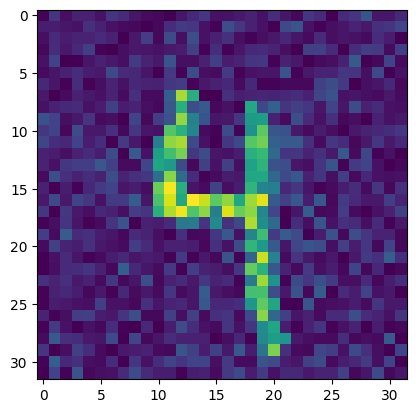

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.2574840472099065
distancia energia distribucion base y el ejemplo natural  0.9175231640889802


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.567365328879551
distancia energia distribucion base y el ejemplo adversario  1.6979072538413176


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-163-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-163-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

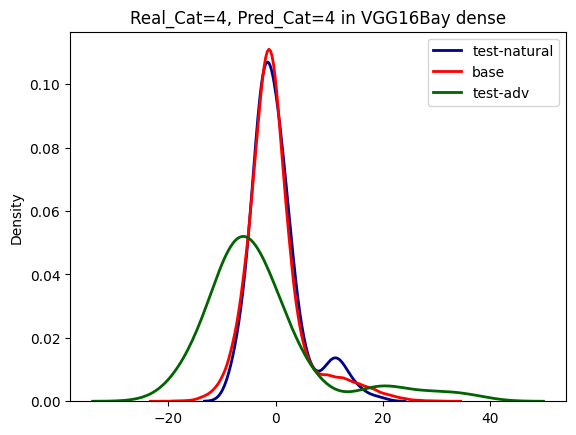

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  4


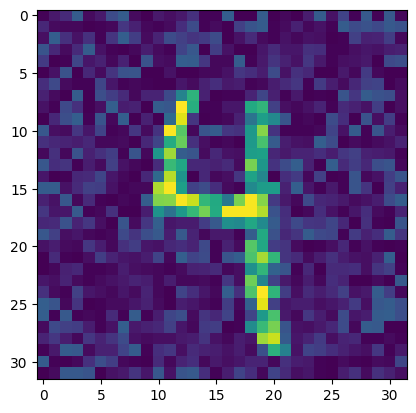

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.9197914574518846
distancia energia distribucion base y el ejemplo natural  0.6974569222780541


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.5953871712720185
distancia energia distribucion base y el ejemplo adversario  2.3965214387561335


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-178-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-178-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

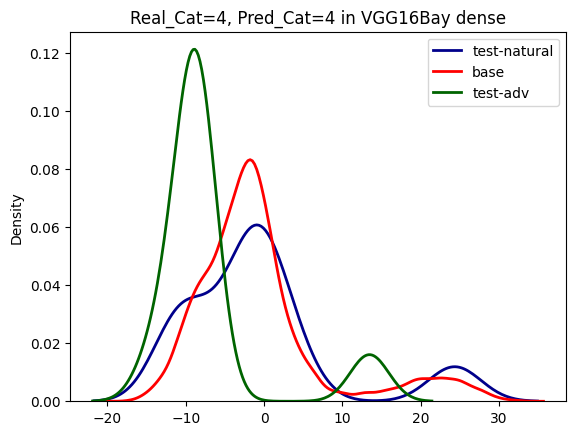

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 61ms/step - loss: 2860.9395 - accuracy: 0.8010


[2860.939453125, 0.8010139465332031]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 59ms/step - loss: 151.7718 - accuracy: 0.9873


[151.7718048095703, 0.9873257279396057]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  4


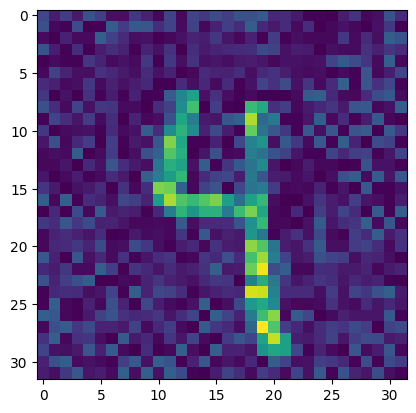

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.442111588298811
distancia energia distribucion base y el ejemplo natural  0.9646544341450174


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.817983572031922
distancia energia distribucion base y el ejemplo adversario  1.4341448738553872


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-197-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-197-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

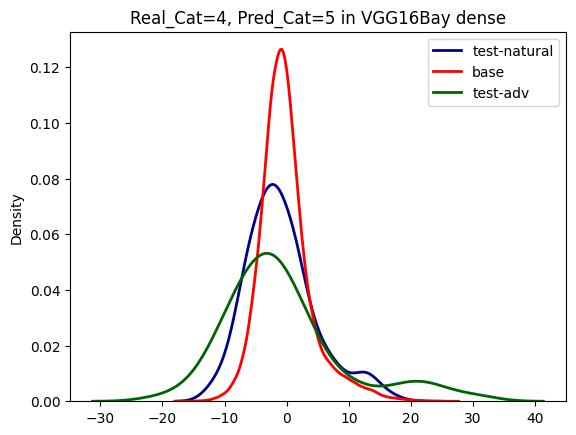

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  4


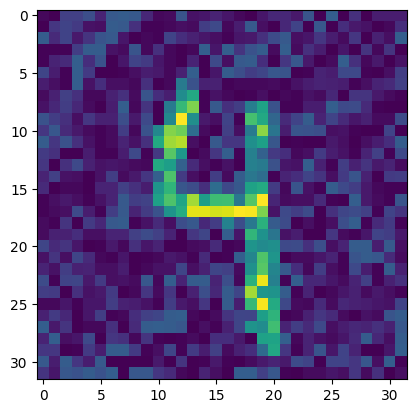

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.6926139471666506
distancia energia distribucion base y el ejemplo natural  0.8917213581219667


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  8.258436952140237
distancia energia distribucion base y el ejemplo adversario  3.000356610077597


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-212-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-212-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

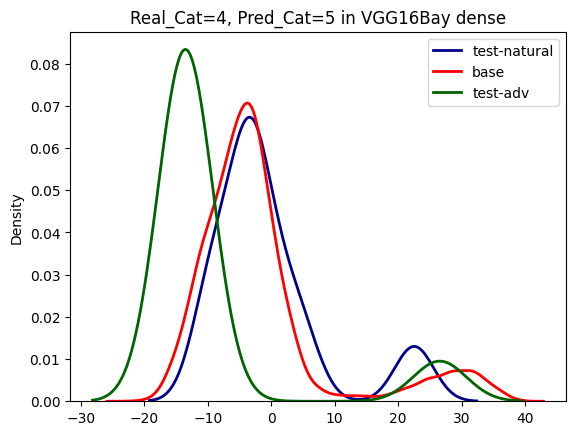

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 2860.3909 - accuracy: 0.9608


[2860.390869140625, 0.9608269929885864]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 151.6950 - accuracy: 0.9935


[151.69497680664062, 0.9934711456298828]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  4


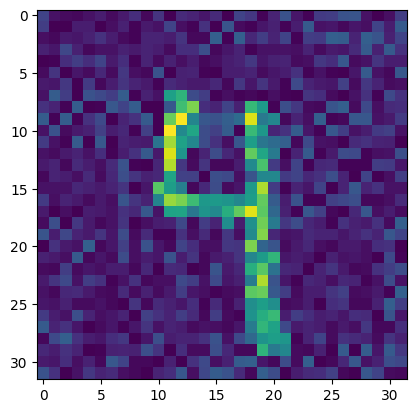

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3103929824218077
distancia energia distribucion base y el ejemplo natural  0.8526702214386586


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.8411038381934994
distancia energia distribucion base y el ejemplo adversario  1.1643598414749028


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-231-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-231-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

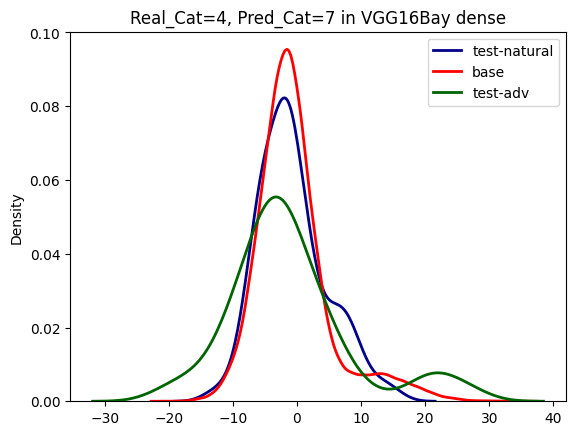

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  4


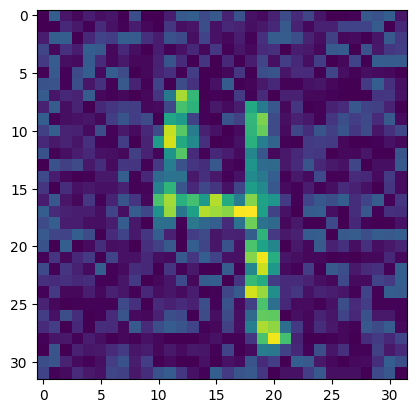

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1560443310800292
distancia energia distribucion base y el ejemplo natural  0.7468815670170513


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  8.665324054413738
distancia energia distribucion base y el ejemplo adversario  2.9801418755740774


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-246-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-246-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

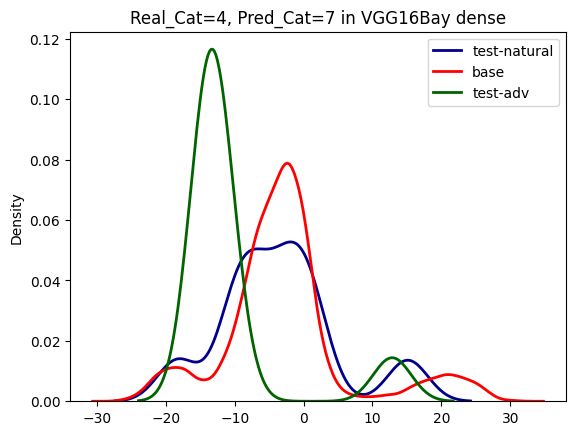

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 69ms/step - loss: 2860.4661 - accuracy: 0.9434


[2860.466064453125, 0.9434388875961304]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 65ms/step - loss: 151.8145 - accuracy: 0.9785


[151.81451416015625, 0.9785068035125732]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  4


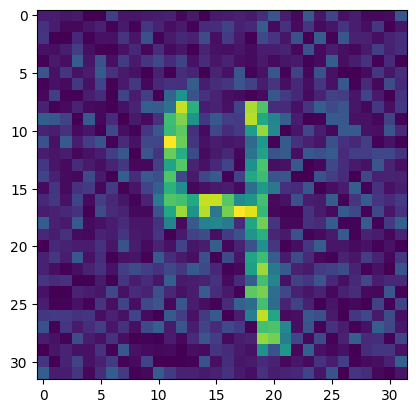

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5011606766526253
distancia energia distribucion base y el ejemplo natural  0.7100831769538755


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.709964102838048
distancia energia distribucion base y el ejemplo adversario  1.277859862237887


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-265-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-265-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

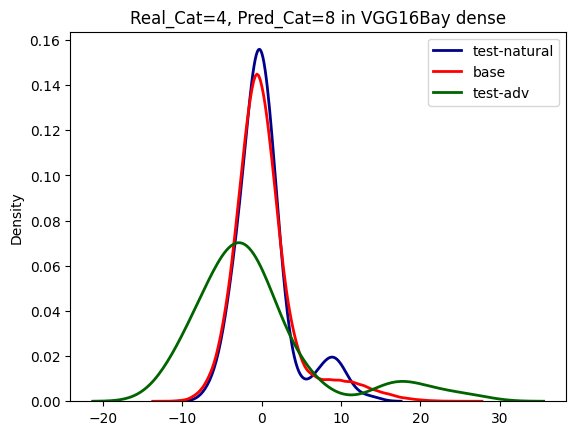

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  4


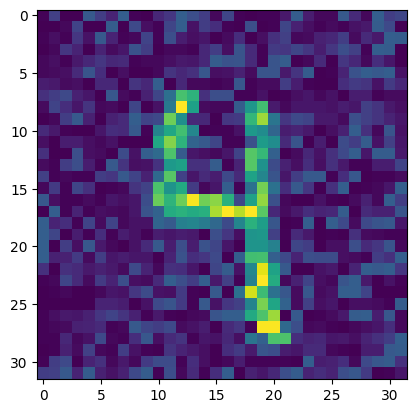

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3083195389480813
distancia energia distribucion base y el ejemplo natural  0.8398295502160267


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.606419674385138
distancia energia distribucion base y el ejemplo adversario  2.902157727443152


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-280-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-280-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

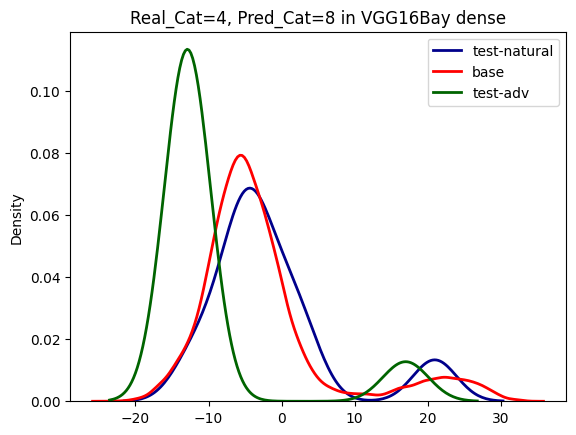

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 2860.6223 - accuracy: 0.8915


[2860.622314453125, 0.8914728760719299]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 57ms/step - loss: 151.7751 - accuracy: 0.9812


[151.77513122558594, 0.9811738729476929]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  4


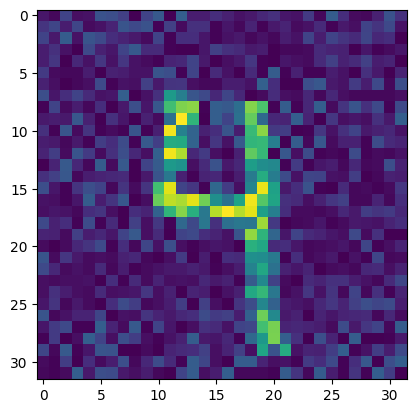

In [291]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [292]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [293]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [294]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [295]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6114636010917236
distancia energia distribucion base y el ejemplo natural  0.734417136056255


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.543241435762175
distancia energia distribucion base y el ejemplo adversario  1.4520067315356564


In [298]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-299-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-299-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

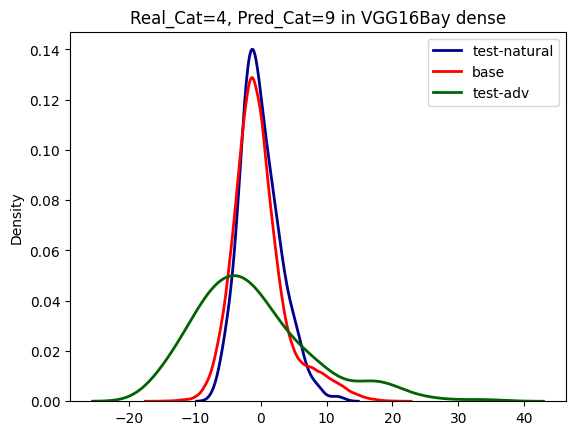

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [301]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  4


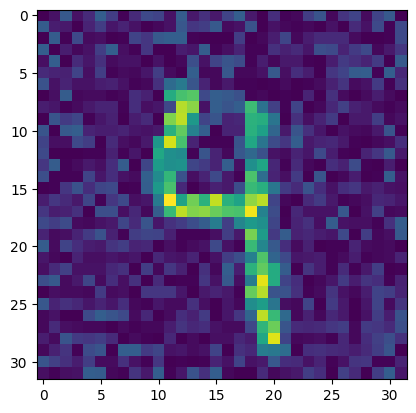

In [306]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [307]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [308]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [309]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [310]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6435054191515144
distancia energia distribucion base y el ejemplo natural  0.6565015485077854


In [311]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [312]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.903285388978381
distancia energia distribucion base y el ejemplo adversario  2.442458455182483


In [313]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-314-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-314-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

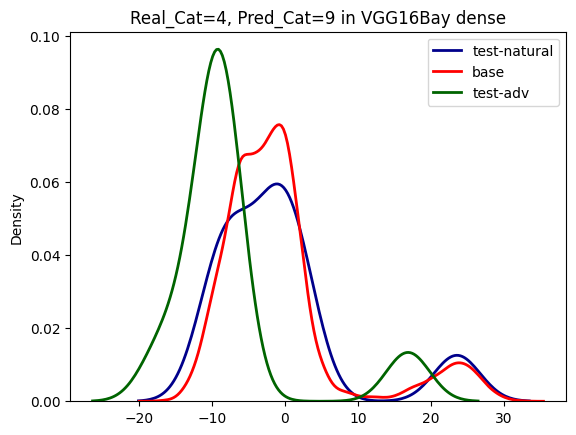

In [314]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 7

## Ataque 0

In [315]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 7
Vic_loc = 21
Cat = 0

In [316]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [317]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 65ms/step - loss: 2860.3293 - accuracy: 0.9729


[2860.329345703125, 0.9728813767433167]

In [318]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 72ms/step - loss: 151.6920 - accuracy: 0.9977


[151.69195556640625, 0.9977400898933411]

### vgg_b1R

In [319]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [320]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [321]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [322]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [323]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [324]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


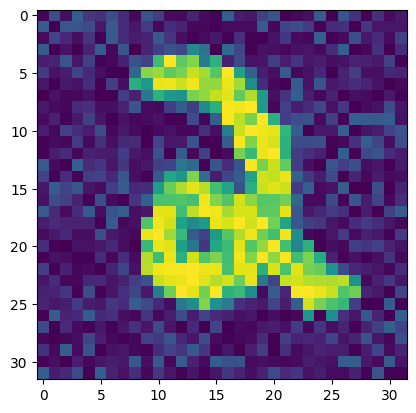

In [325]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [326]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [327]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [328]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [329]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.9988920358138569
distancia energia distribucion base y el ejemplo natural  0.7910384118454648


In [330]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [331]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.8443774856117323
distancia energia distribucion base y el ejemplo adversario  1.1726320515306627


In [332]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-333-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-333-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

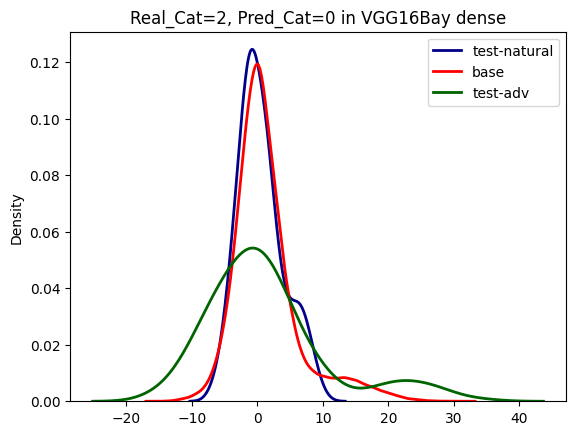

In [333]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [334]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [335]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [336]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [337]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [338]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [339]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


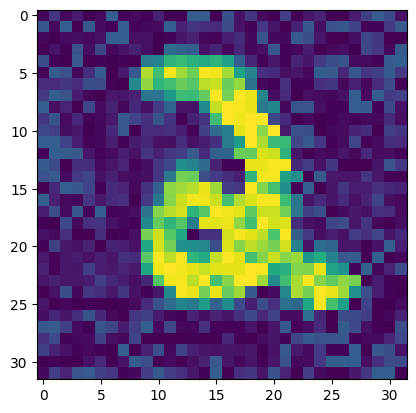

In [340]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [341]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [342]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [343]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [344]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.242580846680498
distancia energia distribucion base y el ejemplo natural  1.1386213458594179


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.456703038254505
distancia energia distribucion base y el ejemplo adversario  2.7499278182063733


In [347]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-348-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-348-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

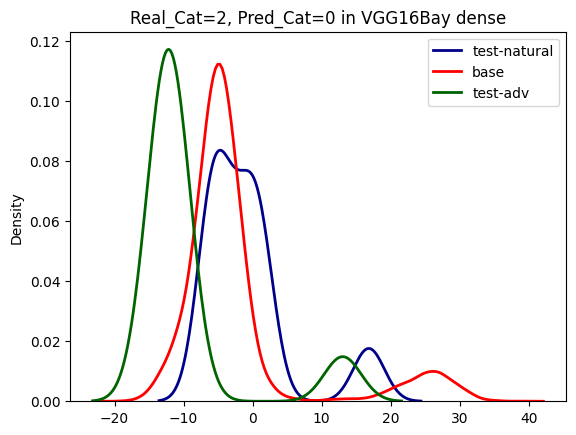

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [349]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [351]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 65ms/step - loss: 2860.3418 - accuracy: 0.9736


[2860.341796875, 0.973555326461792]

In [352]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 64ms/step - loss: 151.6864 - accuracy: 0.9951


[151.6864471435547, 0.9951028227806091]

### vgg_b1R

In [353]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [355]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


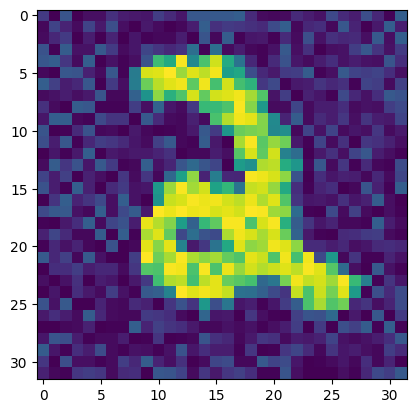

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6590301443752369
distancia energia distribucion base y el ejemplo natural  0.7507550515399115


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [365]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.2989458402247567
distancia energia distribucion base y el ejemplo adversario  1.26063204227122


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-367-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-367-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

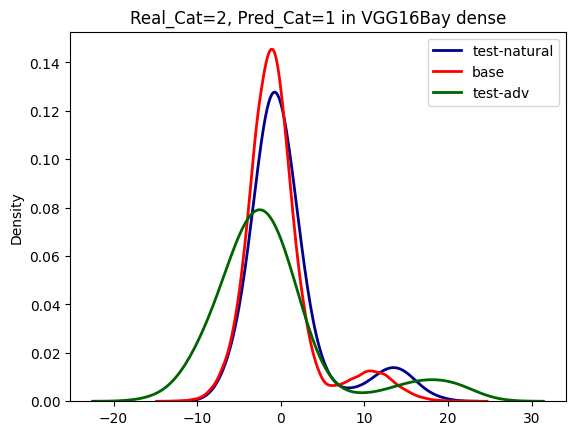

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


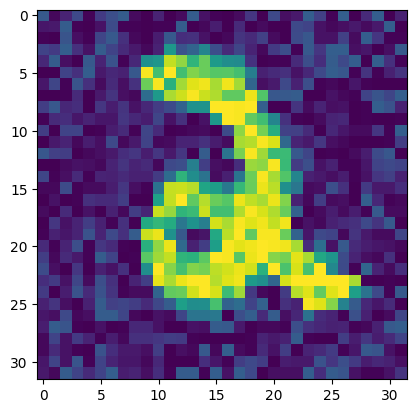

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [375]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.4106870078314016
distancia energia distribucion base y el ejemplo natural  0.6569889253349228


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  8.777709329178919
distancia energia distribucion base y el ejemplo adversario  3.1084031878549165


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-382-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-382-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

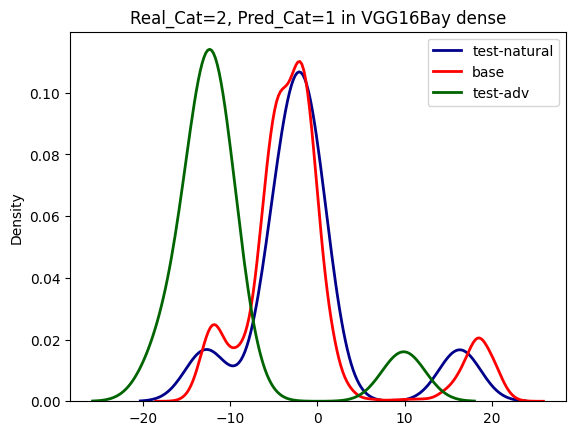

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 64ms/step - loss: 2860.4280 - accuracy: 0.9479


[2860.427978515625, 0.9478723406791687]

In [386]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 60ms/step - loss: 151.7374 - accuracy: 0.9883


[151.73736572265625, 0.9882978796958923]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


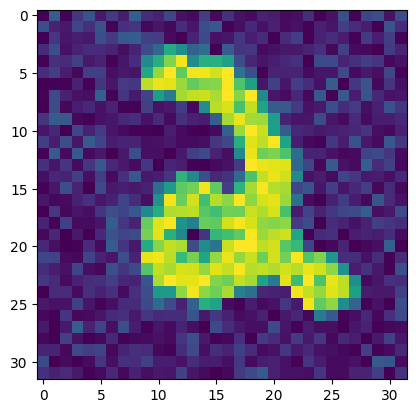

In [393]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.2606882233880783
distancia energia distribucion base y el ejemplo natural  0.8678521189989777


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.4748952890430855
distancia energia distribucion base y el ejemplo adversario  1.5165505997551212


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-401-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-401-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

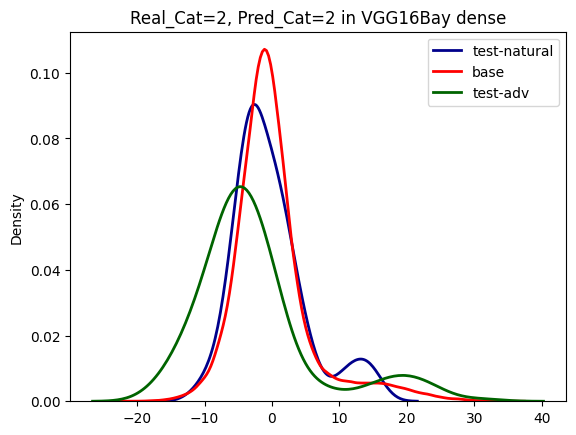

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [407]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


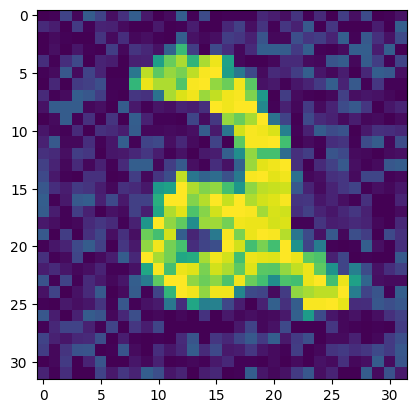

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.096948253367388
distancia energia distribucion base y el ejemplo natural  0.8404870653902337


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  10.802190356708973
distancia energia distribucion base y el ejemplo adversario  3.769339028743167


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-416-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-416-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

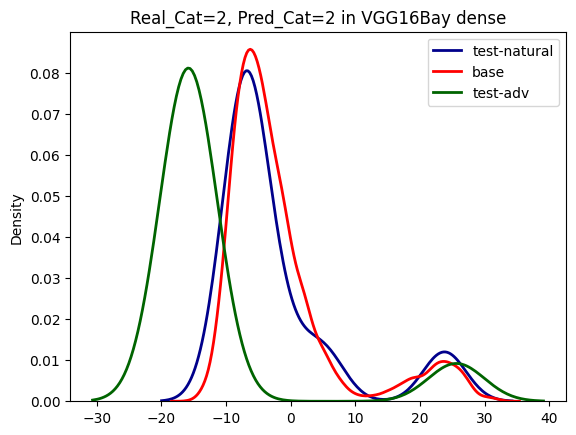

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [418]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 2860.3811 - accuracy: 0.9593


[2860.381103515625, 0.959295928478241]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 58ms/step - loss: 151.6964 - accuracy: 0.9912


[151.6964111328125, 0.9911991357803345]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


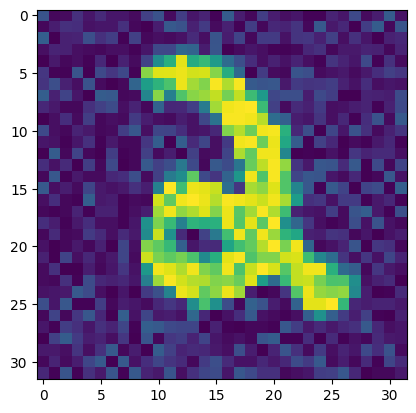

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [430]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.0832327669844597
distancia energia distribucion base y el ejemplo natural  0.8651916052421512


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.04650077936762
distancia energia distribucion base y el ejemplo adversario  1.3571825203114039


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-435-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-435-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

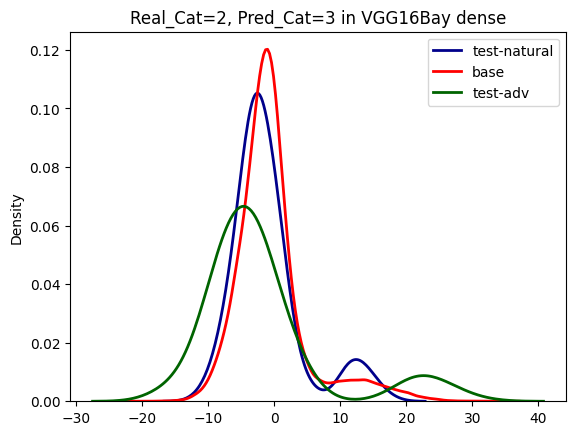

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


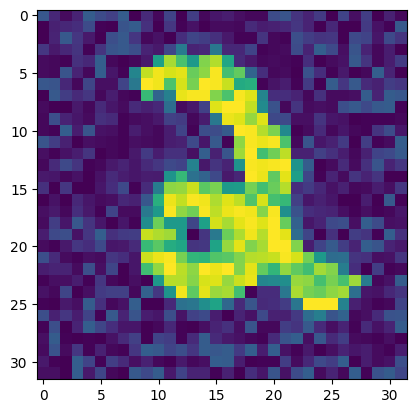

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [444]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1961908964351498
distancia energia distribucion base y el ejemplo natural  0.7368995231341348


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.287217371795082
distancia energia distribucion base y el ejemplo adversario  2.1664481562204725


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-450-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-450-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

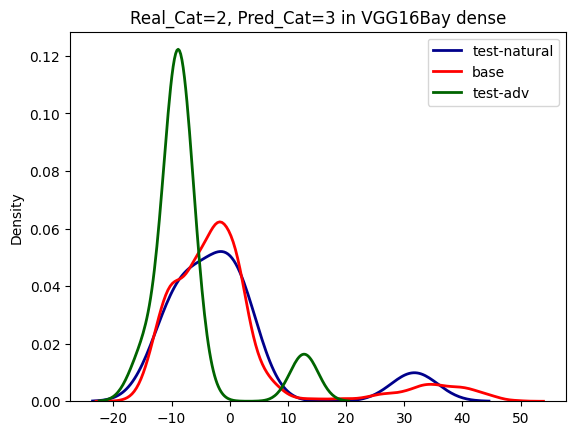

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 67ms/step - loss: 2860.3909 - accuracy: 0.9603


[2860.390869140625, 0.9602724313735962]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 72ms/step - loss: 151.7664 - accuracy: 0.9841


[151.76641845703125, 0.9841089844703674]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [460]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


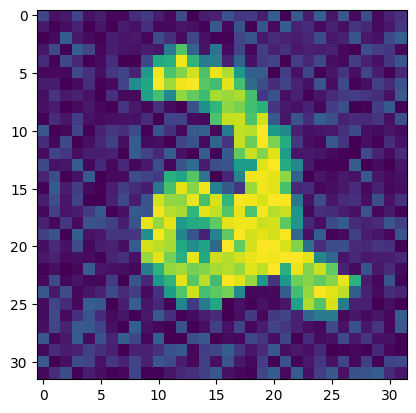

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.164508869644523
distancia energia distribucion base y el ejemplo natural  0.8627890508126808


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.380298442117089
distancia energia distribucion base y el ejemplo adversario  1.4293205950950811


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-469-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-469-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

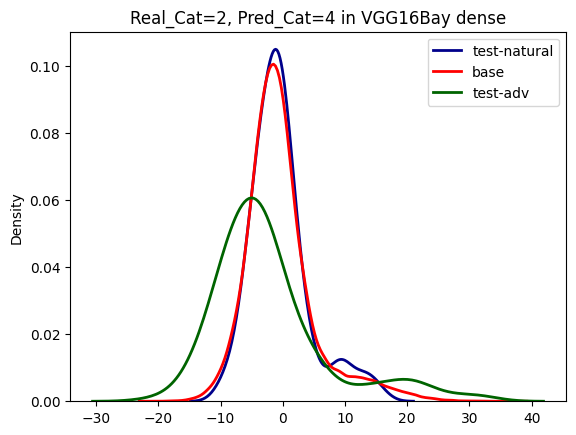

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [475]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


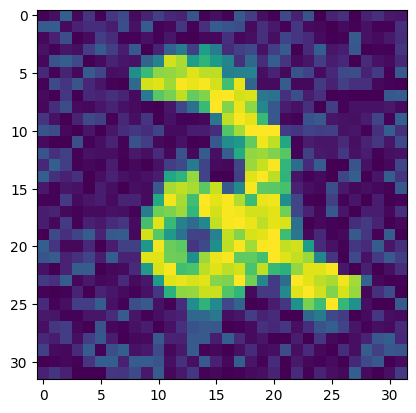

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.9168194282771642
distancia energia distribucion base y el ejemplo natural  0.6972068876272063


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.675616070736311
distancia energia distribucion base y el ejemplo adversario  1.6163338194273893


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-484-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-484-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

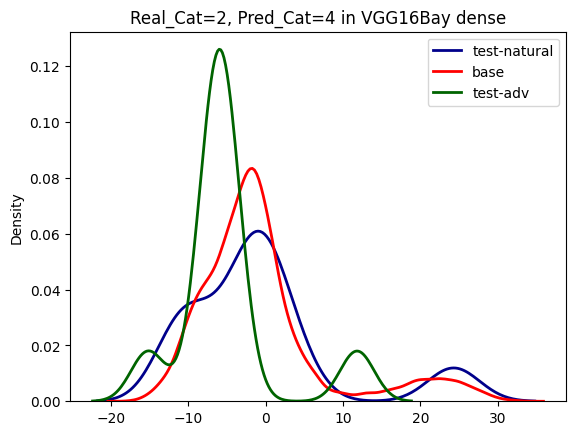

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 63ms/step - loss: 2860.8386 - accuracy: 0.8200


[2860.838623046875, 0.8200253248214722]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 63ms/step - loss: 151.7697 - accuracy: 0.9886


[151.7697296142578, 0.9885931611061096]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [491]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


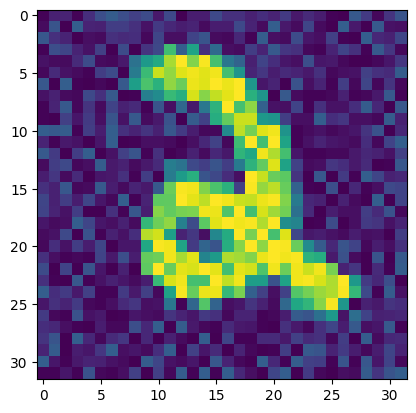

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[3]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.326971942700995
distancia energia distribucion base y el ejemplo natural  0.8915656041228331


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.030991734675568
distancia energia distribucion base y el ejemplo adversario  1.3250333947196196


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-503-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-503-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

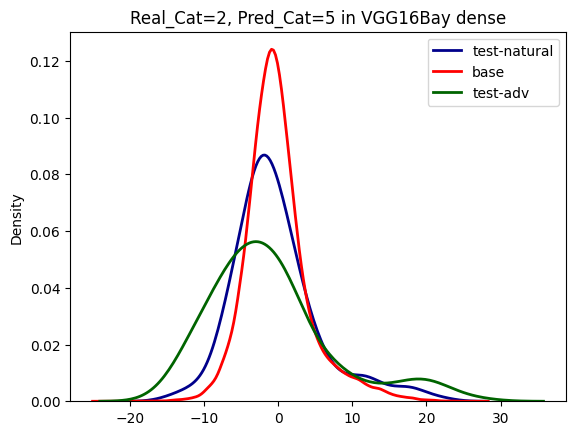

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [509]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


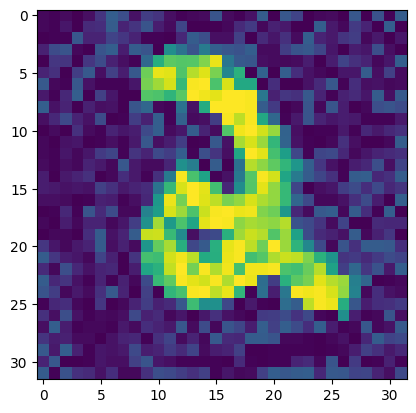

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.6777173616344214
distancia energia distribucion base y el ejemplo natural  0.8887155827846469


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  9.194472386926957
distancia energia distribucion base y el ejemplo adversario  2.9162350640435024


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-518-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-518-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

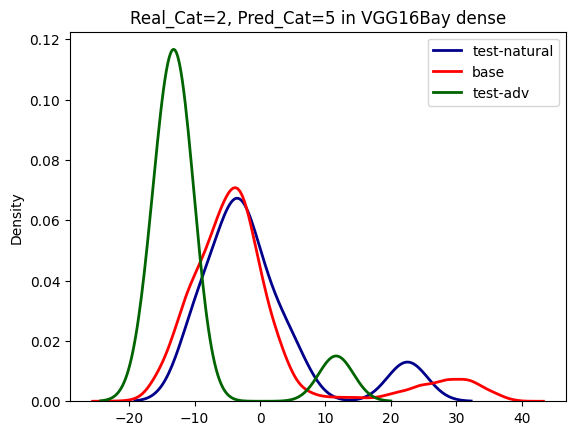

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 68ms/step - loss: 2860.3582 - accuracy: 0.9666


[2860.358154296875, 0.9666283130645752]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 71ms/step - loss: 151.7859 - accuracy: 0.9816


[151.78591918945312, 0.9815880060195923]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [527]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


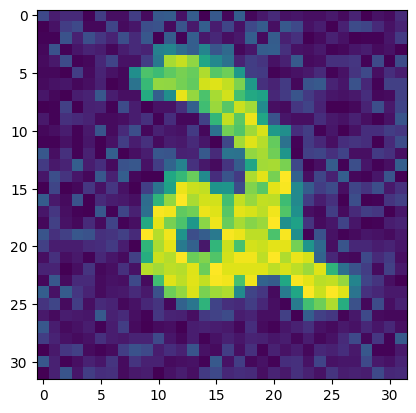

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1053262814697176
distancia energia distribucion base y el ejemplo natural  0.8461018444611705


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.087751877283758
distancia energia distribucion base y el ejemplo adversario  1.143894658717426


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-537-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-537-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

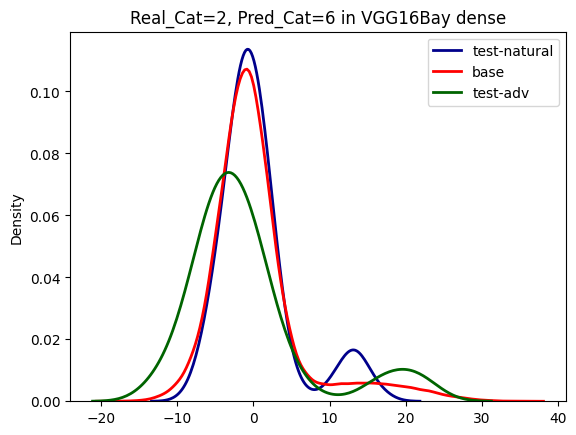

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


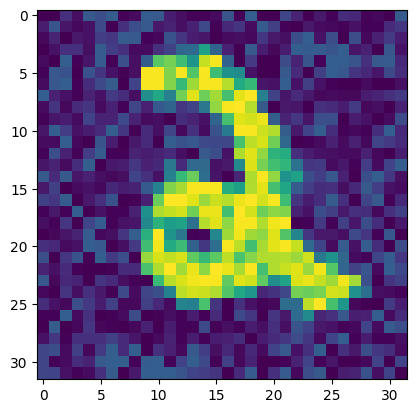

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [547]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.5153520015254163
distancia energia distribucion base y el ejemplo natural  0.7857174630607136


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.337615445463076
distancia energia distribucion base y el ejemplo adversario  2.3421172782101753


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-552-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-552-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

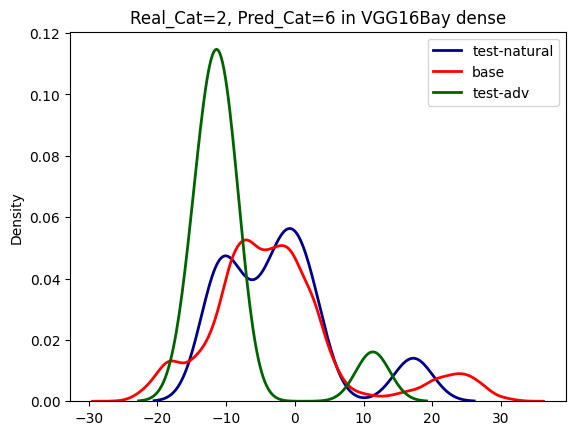

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 72ms/step - loss: 2860.5256 - accuracy: 0.9208


[2860.525634765625, 0.9208144545555115]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 72ms/step - loss: 151.8100 - accuracy: 0.9785


[151.81004333496094, 0.9785068035125732]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


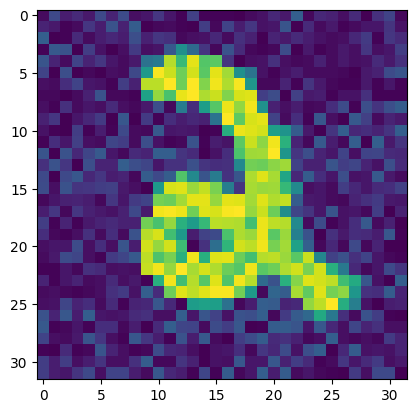

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5155629974188165
distancia energia distribucion base y el ejemplo natural  0.7126110176061421


In [568]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.9681766518756687
distancia energia distribucion base y el ejemplo adversario  1.2251949473582022


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-571-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-571-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

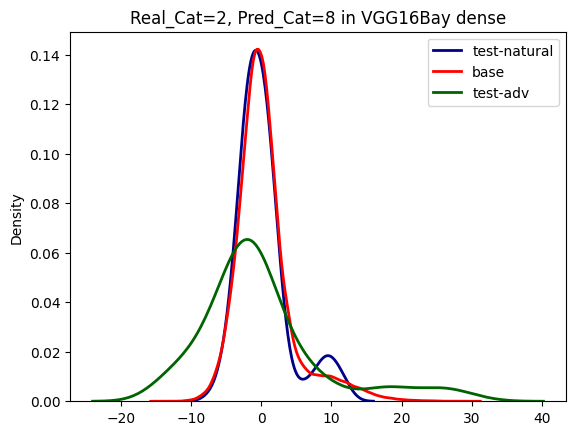

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


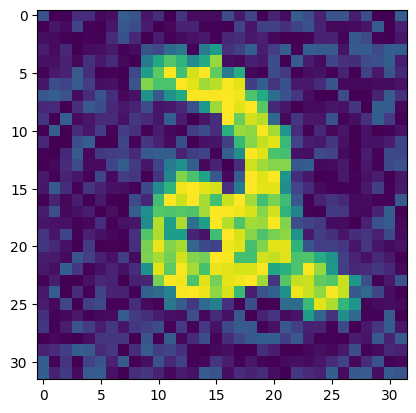

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3094767047287843
distancia energia distribucion base y el ejemplo natural  0.8402307268178341


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.235200569708119
distancia energia distribucion base y el ejemplo adversario  2.7018526498078037


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-586-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-586-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

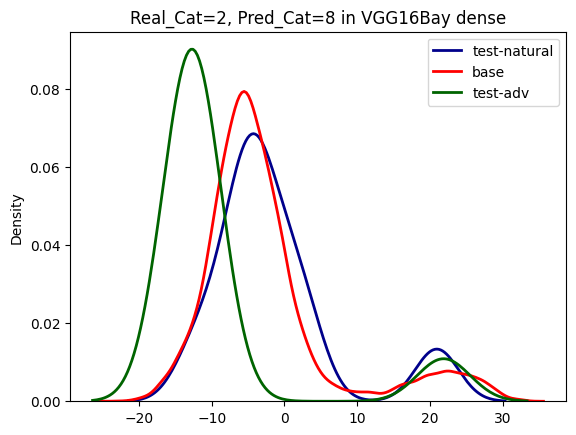

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [589]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 65ms/step - loss: 2860.6567 - accuracy: 0.8771


[2860.65673828125, 0.8770763874053955]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 60ms/step - loss: 151.7820 - accuracy: 0.9790


[151.78195190429688, 0.9789590239524841]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


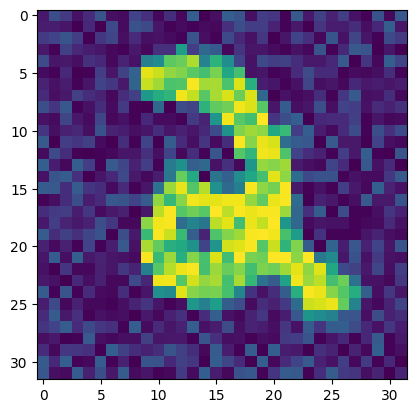

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5995581496389435
distancia energia distribucion base y el ejemplo natural  0.7315033328752779


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9730513625218955
distancia energia distribucion base y el ejemplo adversario  1.0563789717960703


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-605-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-605-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

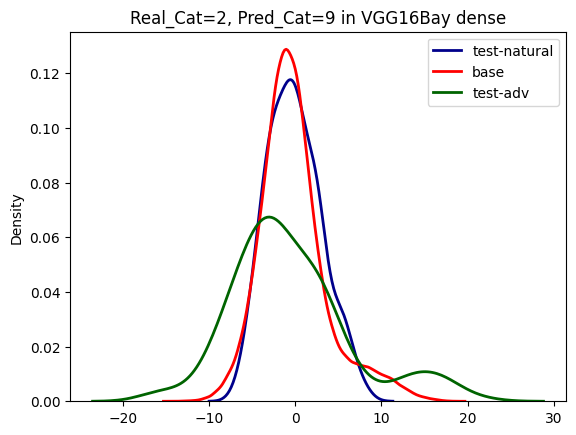

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [608]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


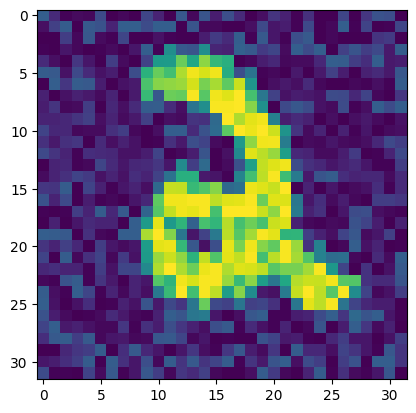

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.636614117009516
distancia energia distribucion base y el ejemplo natural  0.6546318294063252


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  10.08639338637888
distancia energia distribucion base y el ejemplo adversario  3.423995748289524


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-620-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-620-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

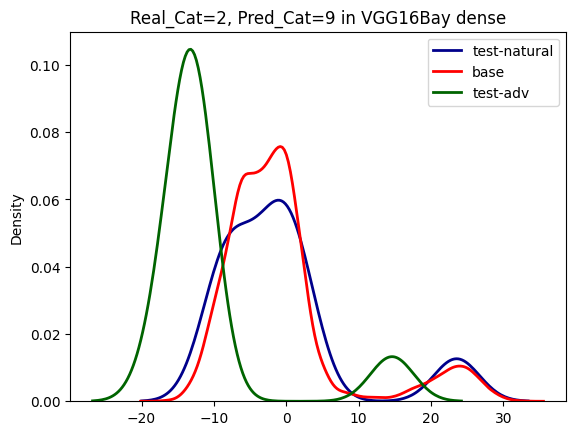

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

# Lista de Variables para Configuración Primer Epxilon

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = '015'
Epx_val = 0.15
DS = DS

# Victima 6

## Ataque 0

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 6
Vic_loc = 11
Cat = 0

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 67ms/step - loss: 2860.3630 - accuracy: 0.9627


[2860.363037109375, 0.9627118706703186]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 73ms/step - loss: 151.6937 - accuracy: 0.9977


[151.6937255859375, 0.9977400898933411]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


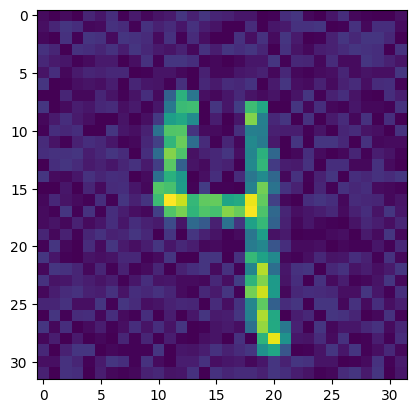

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [634]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.8677738166383937
distancia energia distribucion base y el ejemplo natural  0.7624349905778529


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.492350447399092
distancia energia distribucion base y el ejemplo adversario  0.8952761848368087


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-640-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-640-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

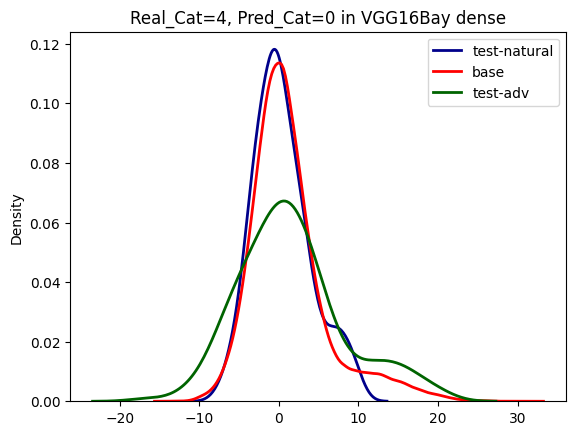

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


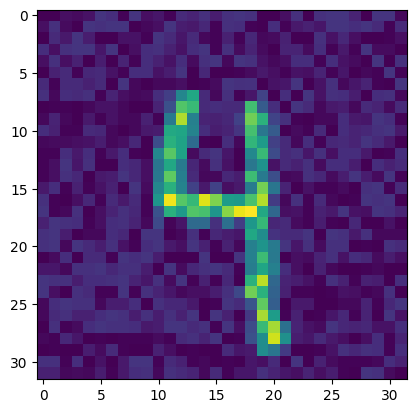

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.244863223946373
distancia energia distribucion base y el ejemplo natural  1.1409420498555396


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.6911749214554694
distancia energia distribucion base y el ejemplo adversario  1.342126275210651


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-655-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-655-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

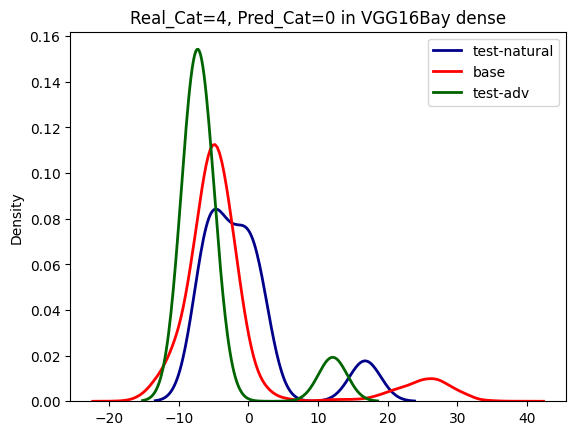

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 66ms/step - loss: 2860.3337 - accuracy: 0.9794


[2860.333740234375, 0.9794319272041321]

In [659]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 62ms/step - loss: 151.6870 - accuracy: 0.9951


[151.68695068359375, 0.9951028227806091]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


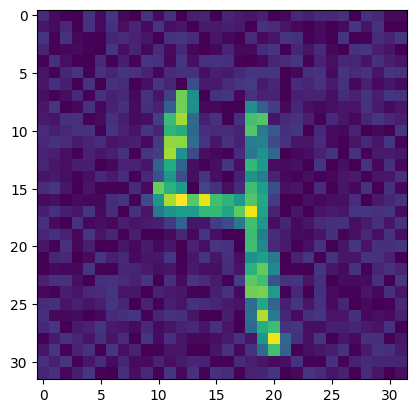

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5976304222786473
distancia energia distribucion base y el ejemplo natural  0.7348081631262082


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.8959952035086753
distancia energia distribucion base y el ejemplo adversario  1.0077344231760945


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-674-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-674-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

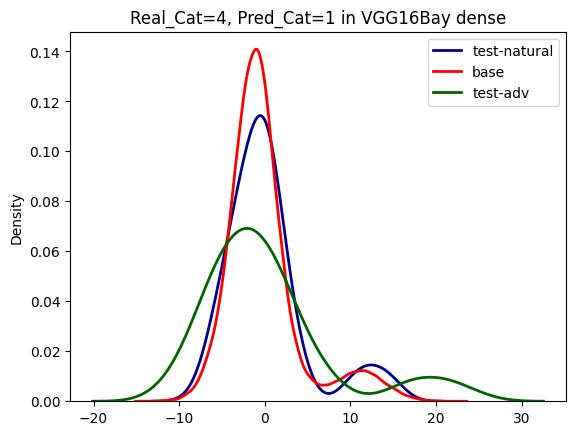

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [680]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


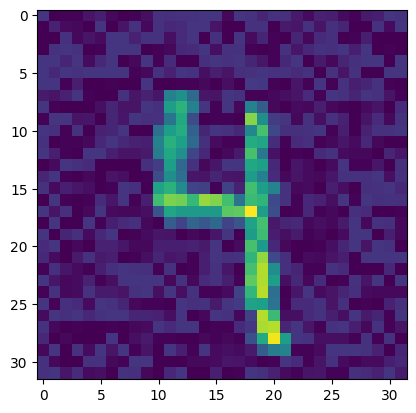

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.4184701429149942
distancia energia distribucion base y el ejemplo natural  0.6610342623731743


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.474989830238695
distancia energia distribucion base y el ejemplo adversario  2.0781479506610805


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-689-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-689-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

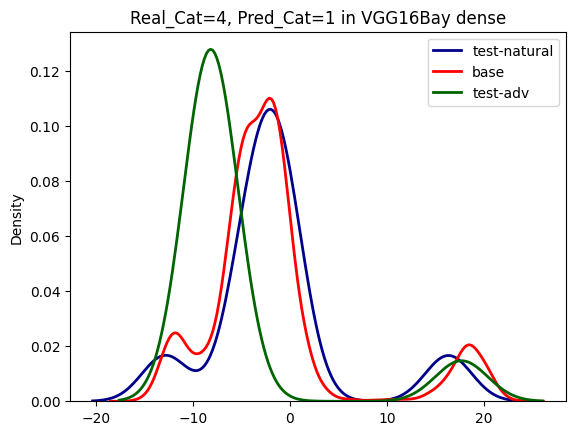

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 65ms/step - loss: 2860.6069 - accuracy: 0.8904


[2860.60693359375, 0.8904255032539368]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 64ms/step - loss: 151.7348 - accuracy: 0.9883


[151.7347869873047, 0.9882978796958923]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


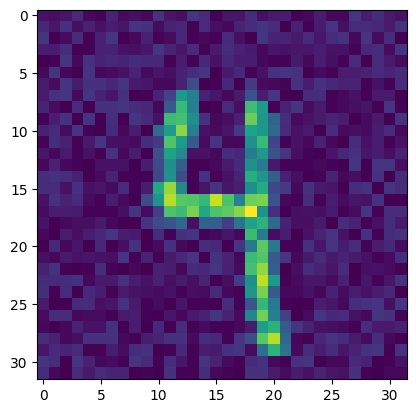

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.331464190704251
distancia energia distribucion base y el ejemplo natural  0.8933593380723068


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [706]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.552458732217074
distancia energia distribucion base y el ejemplo adversario  0.9443915232965404


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-708-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-708-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

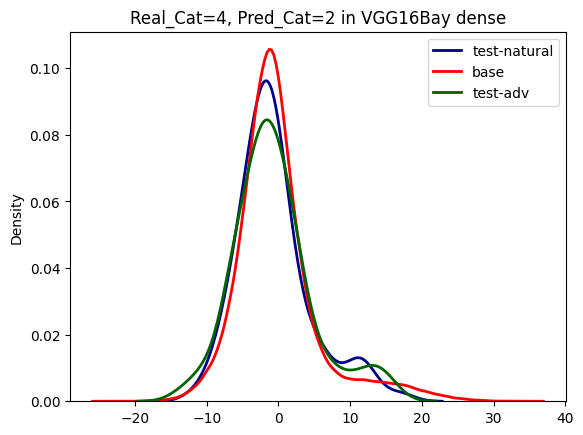

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


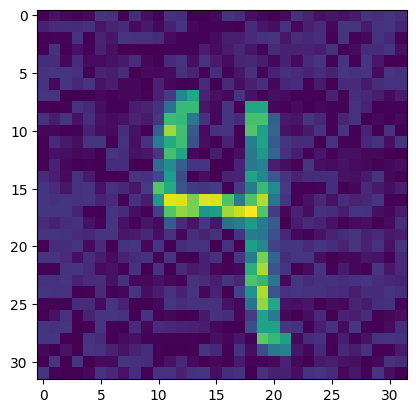

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.082865045439926
distancia energia distribucion base y el ejemplo natural  0.8346591016654613


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.334223289186309
distancia energia distribucion base y el ejemplo adversario  1.8671237905641416


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-723-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-723-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

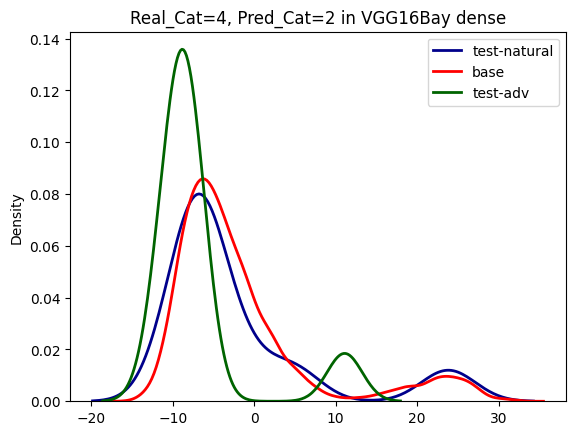

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 62ms/step - loss: 2860.3784 - accuracy: 0.9692


[2860.37841796875, 0.9691969156265259]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 62ms/step - loss: 151.6974 - accuracy: 0.9912


[151.69740295410156, 0.9911991357803345]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


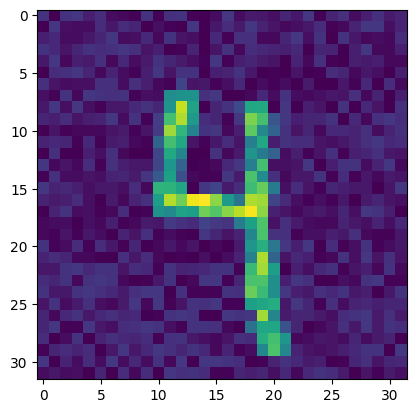

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [735]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.8993052098297762
distancia energia distribucion base y el ejemplo natural  0.788674163864581


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9807064431099066
distancia energia distribucion base y el ejemplo adversario  1.0938593900995681


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-742-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-742-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

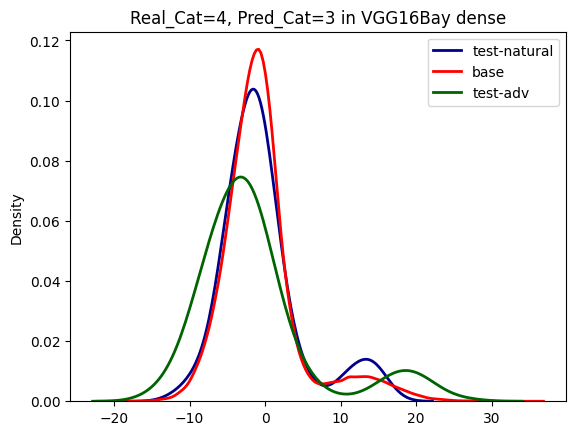

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


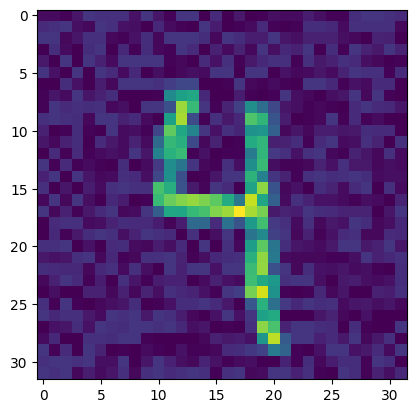

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1890198479795706
distancia energia distribucion base y el ejemplo natural  0.7360067547858045


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.230433672374611
distancia energia distribucion base y el ejemplo adversario  1.8532352952317441


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-757-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-757-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

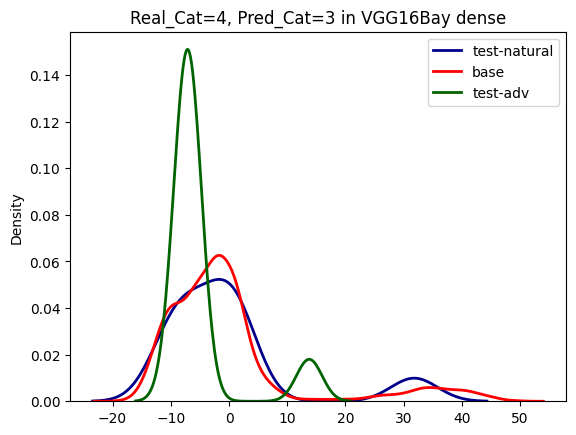

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 67ms/step - loss: 2860.4937 - accuracy: 0.9330


[2860.49365234375, 0.9330306649208069]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 64ms/step - loss: 151.7677 - accuracy: 0.9830


[151.76766967773438, 0.9829738736152649]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [765]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  4


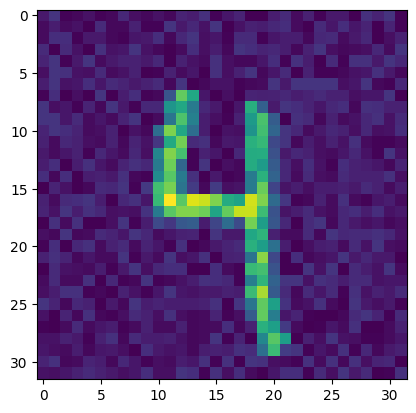

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.205257478145792
distancia energia distribucion base y el ejemplo natural  0.9025217061345643


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.339578723081138
distancia energia distribucion base y el ejemplo adversario  1.3924982926912997


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-776-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-776-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

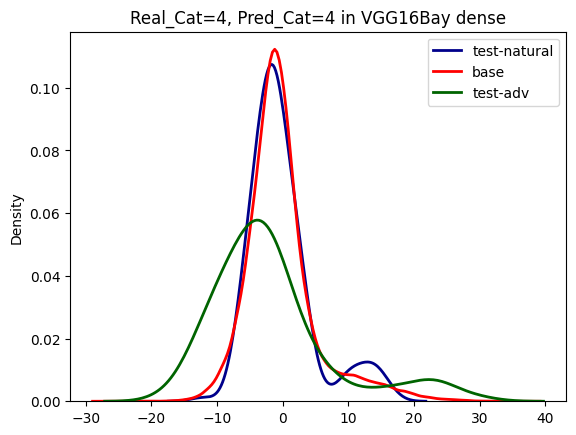

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  4


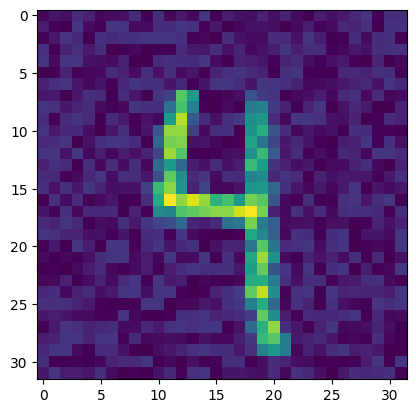

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.9153715558949833
distancia energia distribucion base y el ejemplo natural  0.6960516066101871


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.260869426343666
distancia energia distribucion base y el ejemplo adversario  1.6166190307814736


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-791-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-791-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

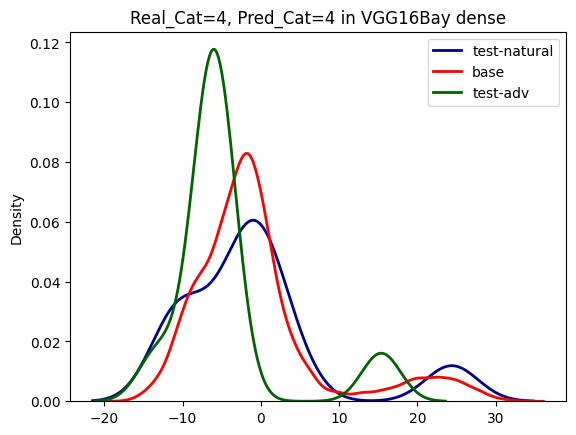

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 65ms/step - loss: 2860.6863 - accuracy: 0.8834


[2860.686279296875, 0.8833966851234436]

In [795]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 62ms/step - loss: 151.7712 - accuracy: 0.9886


[151.7711639404297, 0.9885931611061096]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  4


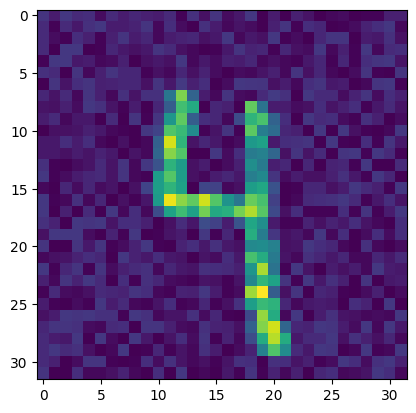

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.273130172217947
distancia energia distribucion base y el ejemplo natural  0.9056205497082943


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.6474768717167447
distancia energia distribucion base y el ejemplo adversario  0.9563858721369408


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-810-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-810-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

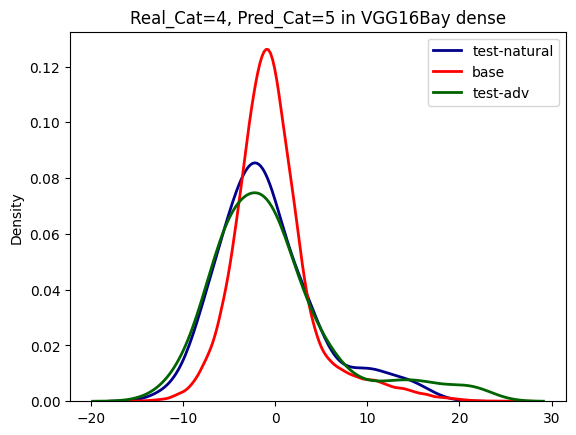

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  4


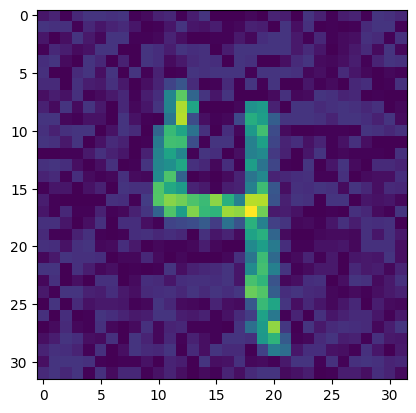

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [821]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.6788389911751977
distancia energia distribucion base y el ejemplo natural  0.8890477849903912


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.8648040461075315
distancia energia distribucion base y el ejemplo adversario  2.1843959867094203


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-825-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-825-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

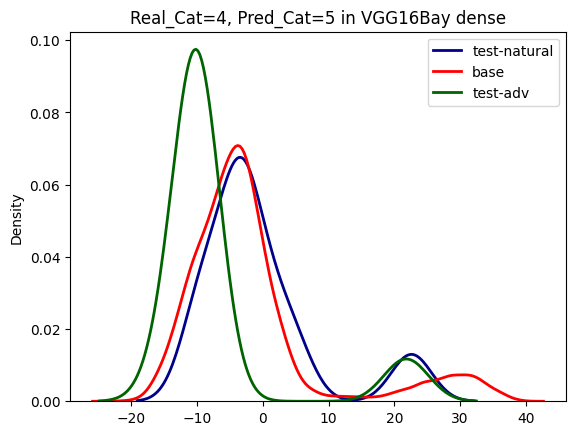

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 64ms/step - loss: 2860.4148 - accuracy: 0.9510


[2860.414794921875, 0.9510337114334106]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 62ms/step - loss: 151.6953 - accuracy: 0.9924


[151.69528198242188, 0.9923830032348633]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  4


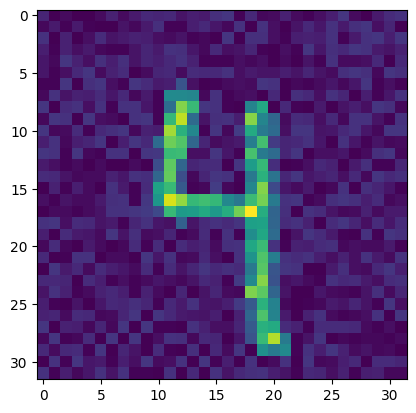

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3190936747689035
distancia energia distribucion base y el ejemplo natural  0.8532156394944197


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.932759274028913
distancia energia distribucion base y el ejemplo adversario  1.2176260038178461


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-844-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-844-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

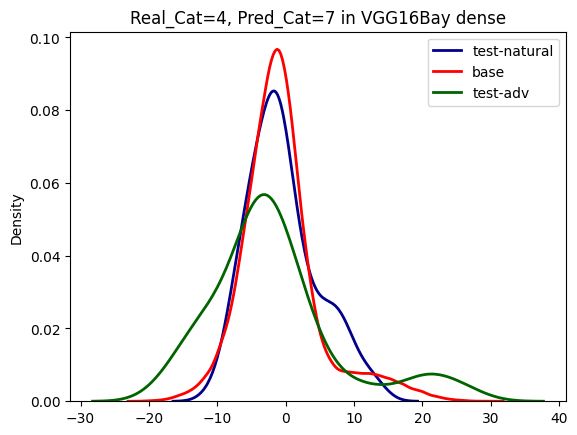

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  4


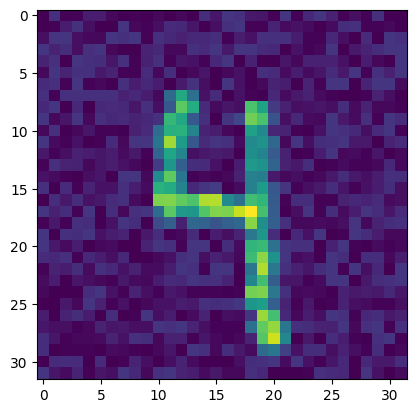

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [853]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.160081090128288
distancia energia distribucion base y el ejemplo natural  0.7467594725433119


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.748854943190183
distancia energia distribucion base y el ejemplo adversario  2.0670472199601173


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-859-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-859-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

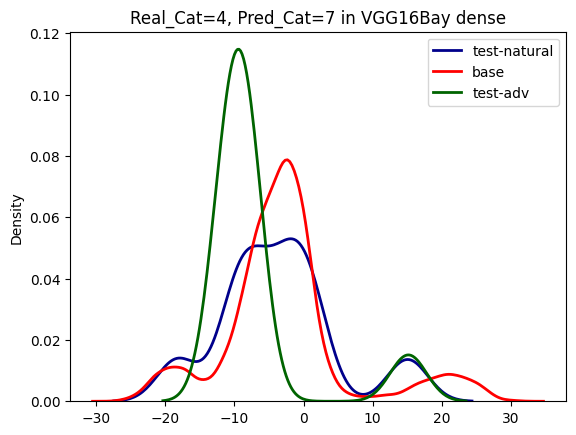

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 67ms/step - loss: 2860.5425 - accuracy: 0.9106


[2860.54248046875, 0.9106335043907166]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 68ms/step - loss: 151.8091 - accuracy: 0.9785


[151.80908203125, 0.9785068035125732]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  4


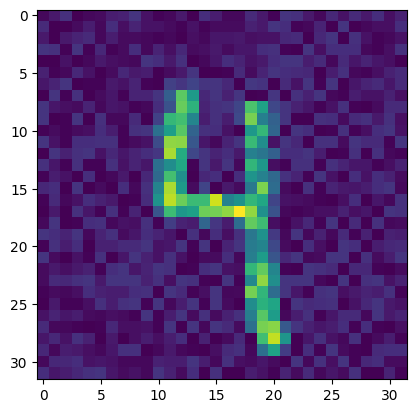

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5124814872656414
distancia energia distribucion base y el ejemplo natural  0.7101254595161918


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9193882076749444
distancia energia distribucion base y el ejemplo adversario  0.9552071289080782


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-878-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-878-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

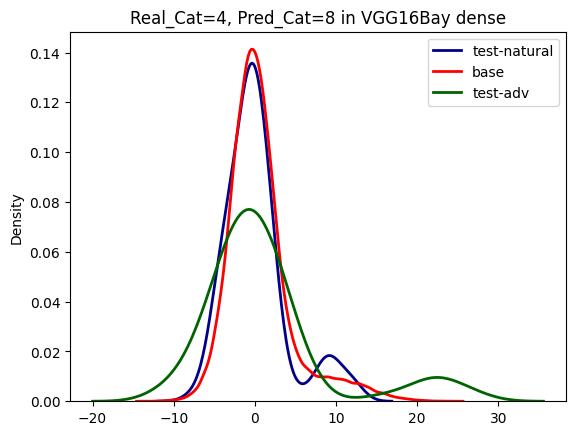

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  4


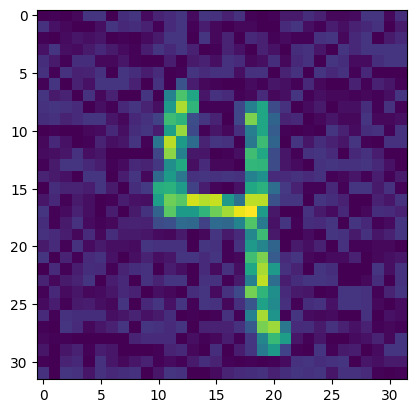

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [886]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3260830313912435
distancia energia distribucion base y el ejemplo natural  0.8422268232443563


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.577730312746332
distancia energia distribucion base y el ejemplo adversario  1.7360922423030951


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-893-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-893-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

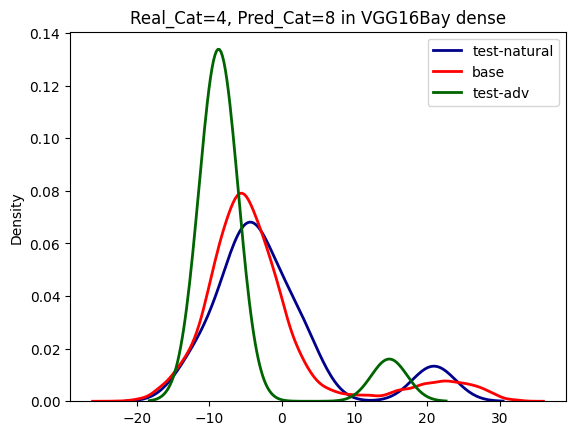

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 65ms/step - loss: 2860.5864 - accuracy: 0.9081


[2860.58642578125, 0.9080841541290283]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 66ms/step - loss: 151.7779 - accuracy: 0.9790


[151.77792358398438, 0.9789590239524841]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  4


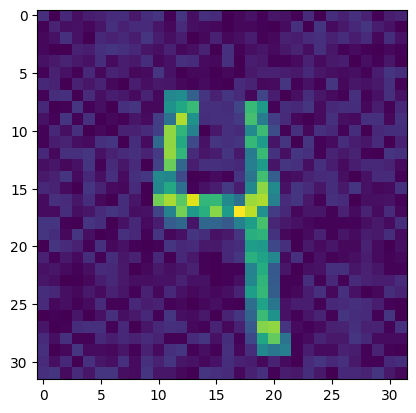

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[7]
[9]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5457211867566452
distancia energia distribucion base y el ejemplo natural  0.7304091596359061


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.3480298221429976
distancia energia distribucion base y el ejemplo adversario  1.1188230123755054


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-912-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-912-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

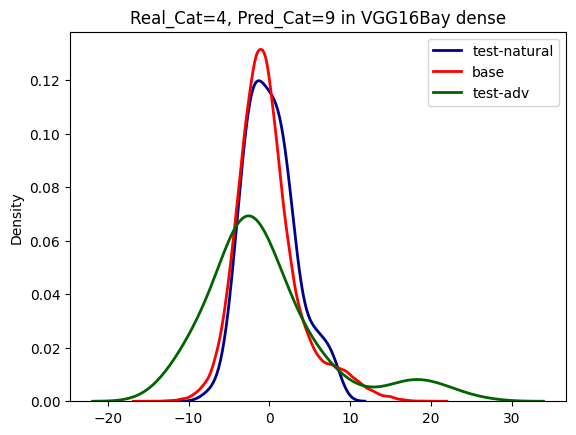

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  4


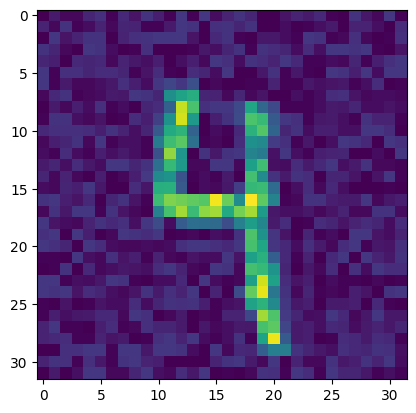

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [921]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6383355441222158
distancia energia distribucion base y el ejemplo natural  0.6549665576772514


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.065090234846311
distancia energia distribucion base y el ejemplo adversario  1.915057511014253


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-927-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-927-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

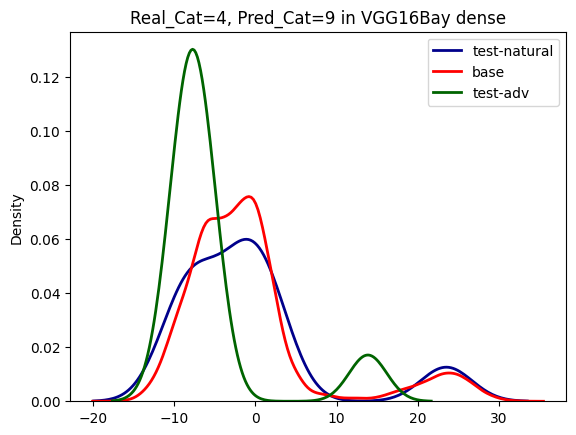

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 7

## Ataque 0

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 7
Vic_loc = 21
Cat = 0

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 68ms/step - loss: 2860.3538 - accuracy: 0.9695


[2860.353759765625, 0.9694915413856506]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 68ms/step - loss: 151.6920 - accuracy: 0.9977


[151.69195556640625, 0.9977400898933411]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


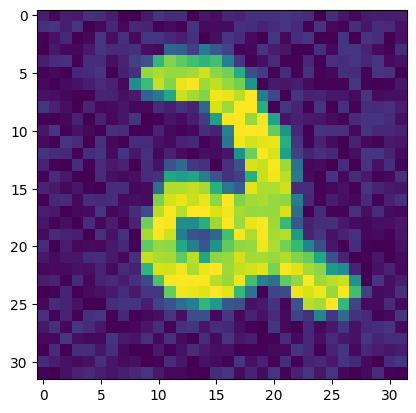

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[6]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.999527584841062
distancia energia distribucion base y el ejemplo natural  0.7875829618044834


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.897792069052528
distancia energia distribucion base y el ejemplo adversario  1.0572279043156658


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-946-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-946-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

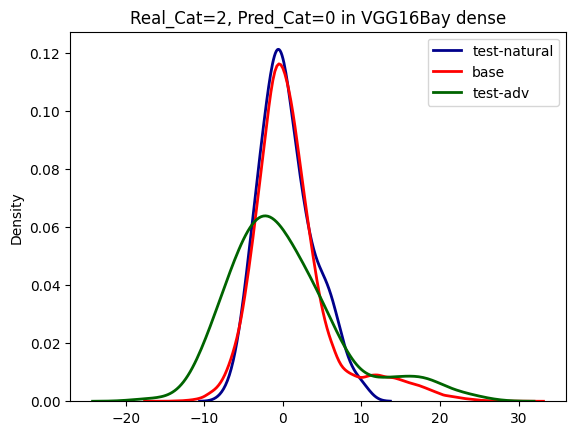

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


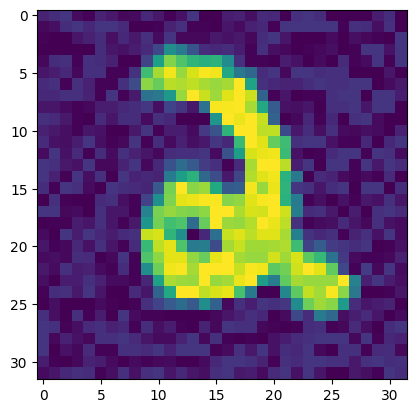

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [956]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.234366288525404
distancia energia distribucion base y el ejemplo natural  1.1368692966439444


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.314601078468325
distancia energia distribucion base y el ejemplo adversario  2.0163853991536786


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-961-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-961-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

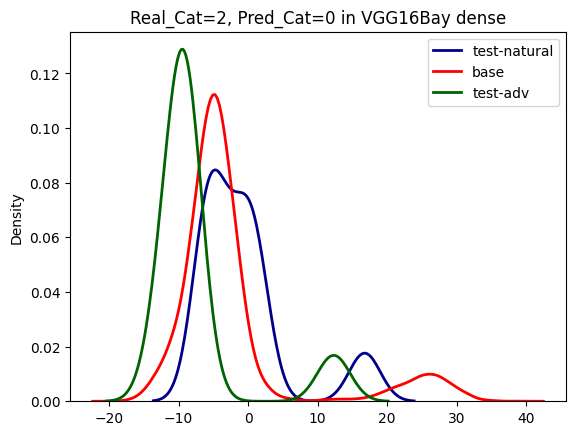

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 70ms/step - loss: 2860.3391 - accuracy: 0.9765


[2860.339111328125, 0.9764936566352844]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 71ms/step - loss: 151.6882 - accuracy: 0.9951


[151.6881866455078, 0.9951028227806091]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


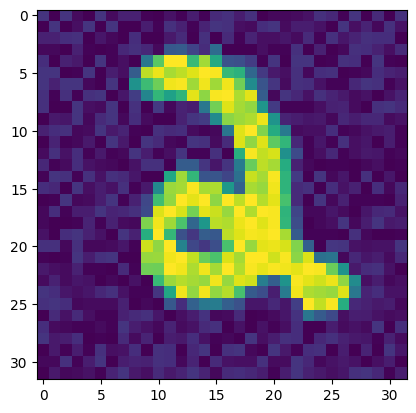

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6070787993450197
distancia energia distribucion base y el ejemplo natural  0.7237146006593567


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.7832543507026517
distancia energia distribucion base y el ejemplo adversario  1.0698973010963355


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-980-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-980-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

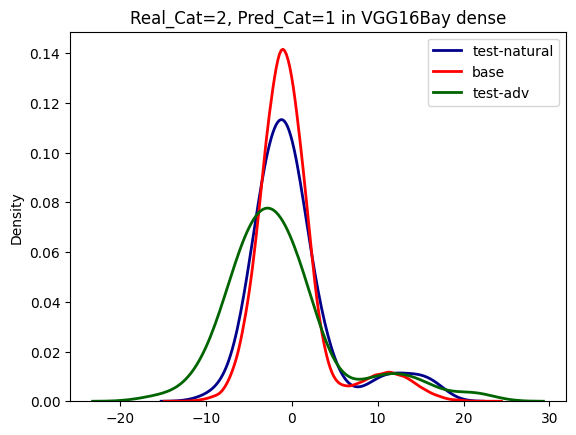

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


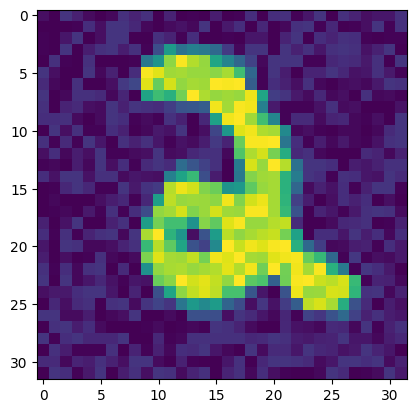

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.4281960677991123
distancia energia distribucion base y el ejemplo natural  0.6638343428980601


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.714049161440472
distancia energia distribucion base y el ejemplo adversario  1.9772953099794601


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-995-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-995-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

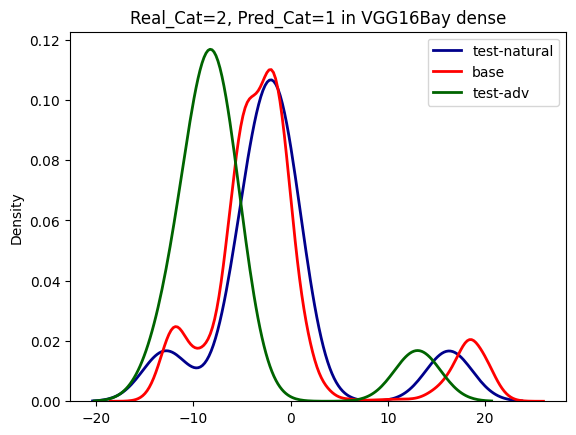

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 63ms/step - loss: 2860.5049 - accuracy: 0.9085


[2860.5048828125, 0.9085106253623962]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 151.7337 - accuracy: 0.9872


[151.73373413085938, 0.9872340559959412]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


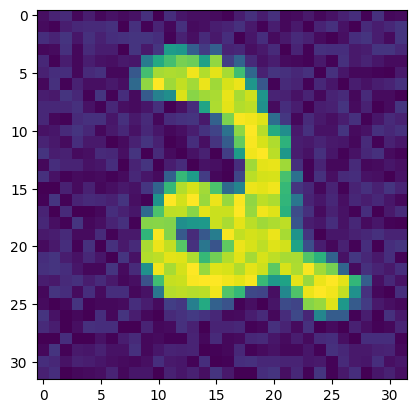

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.335503998964002
distancia energia distribucion base y el ejemplo natural  0.8931562350543002


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.1887231808565435
distancia energia distribucion base y el ejemplo adversario  1.3516218776773692


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1014-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1014-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

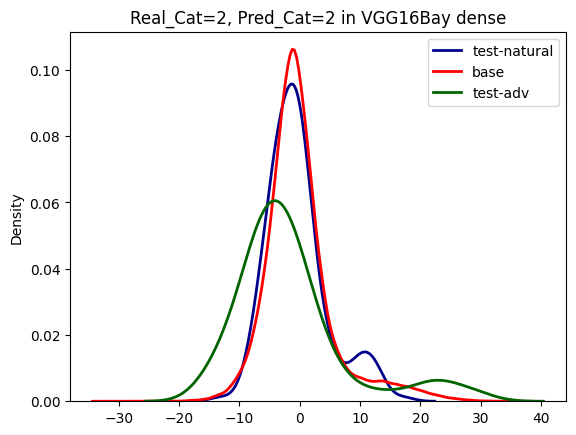

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


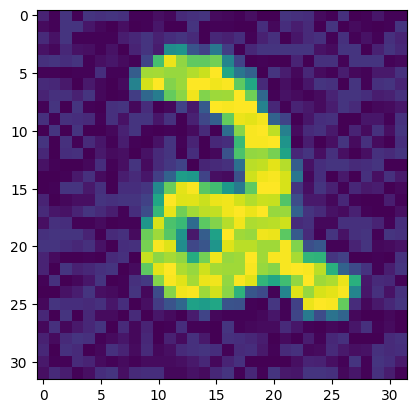

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.095202615539386
distancia energia distribucion base y el ejemplo natural  0.8402990286885299


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  8.594379092103189
distancia energia distribucion base y el ejemplo adversario  3.111247064134218


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1029-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1029-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

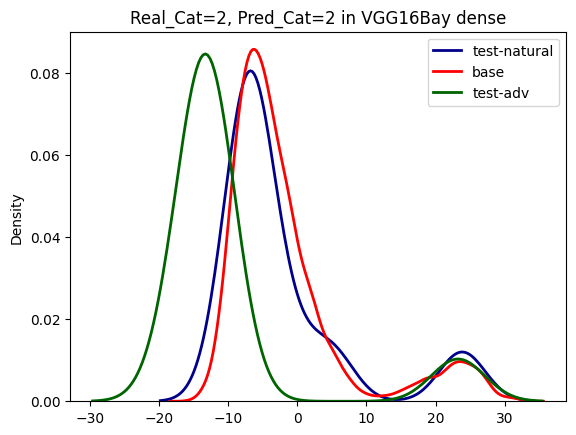

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 61ms/step - loss: 2860.4199 - accuracy: 0.9582


[2860.419921875, 0.9581958055496216]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 65ms/step - loss: 151.6982 - accuracy: 0.9912


[151.69815063476562, 0.9911991357803345]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


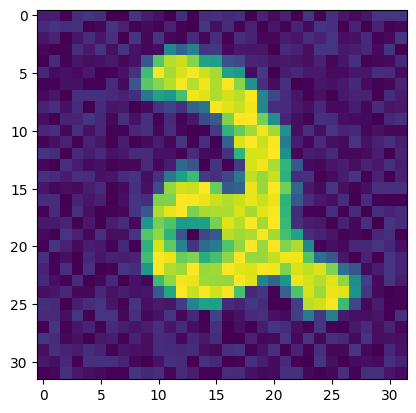

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.9749523865414322
distancia energia distribucion base y el ejemplo natural  0.8144299628545405


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.171806823887608
distancia energia distribucion base y el ejemplo adversario  1.0773407436088116


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1048-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1048-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

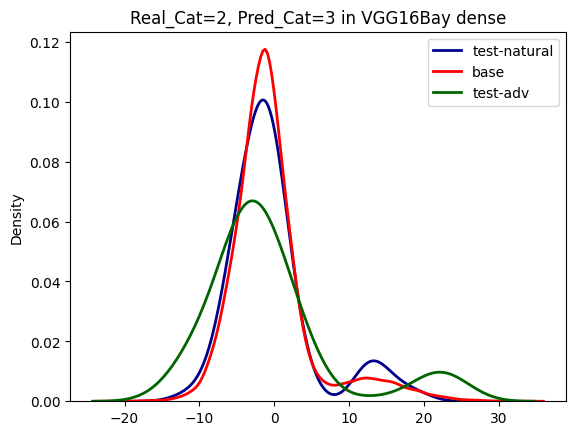

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


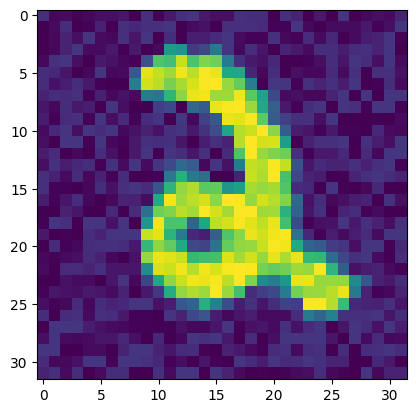

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.191522240490963
distancia energia distribucion base y el ejemplo natural  0.7349116011776902


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.865812648863587
distancia energia distribucion base y el ejemplo adversario  1.5094788335185825


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1063-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1063-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

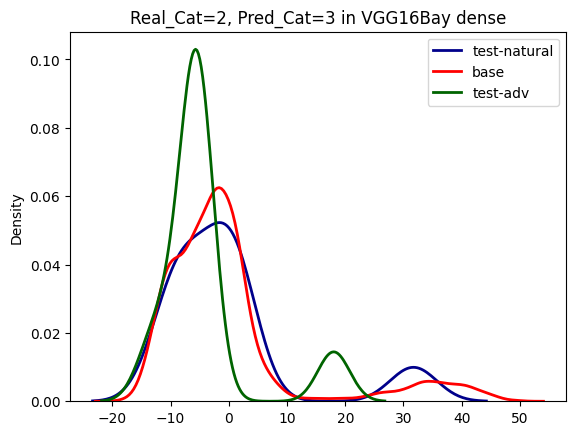

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 67ms/step - loss: 2860.7466 - accuracy: 0.8354


[2860.74658203125, 0.8354142904281616]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 72ms/step - loss: 151.7646 - accuracy: 0.9841


[151.7646484375, 0.9841089844703674]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


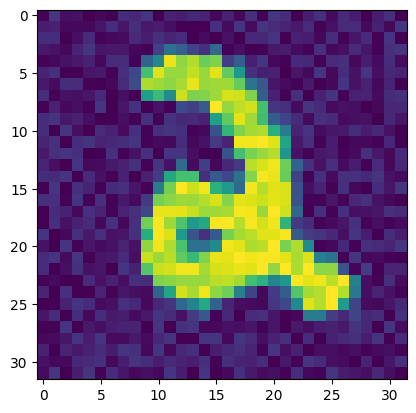

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1258984961673284
distancia energia distribucion base y el ejemplo natural  0.843458334122174


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.002337965937139
distancia energia distribucion base y el ejemplo adversario  1.144214169279237


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1082-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1082-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

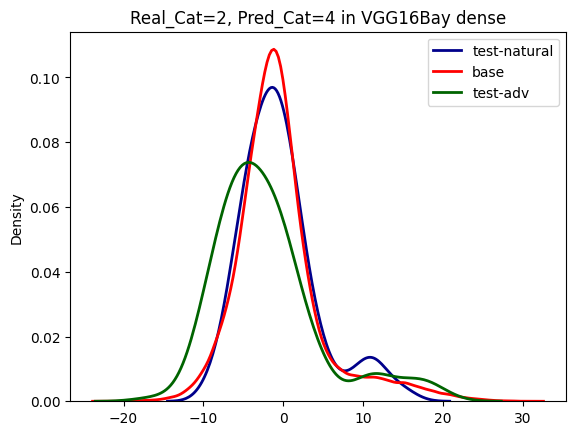

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


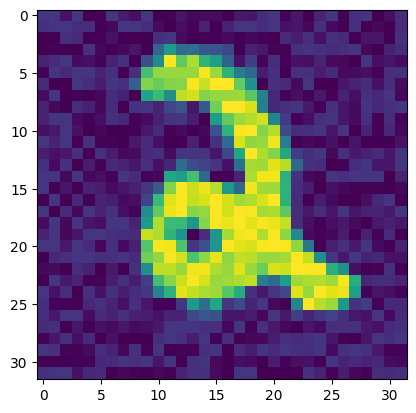

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.899970356180184
distancia energia distribucion base y el ejemplo natural  0.6917414926614832


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.377391221253923
distancia energia distribucion base y el ejemplo adversario  2.2502604450430472


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1097-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1097-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

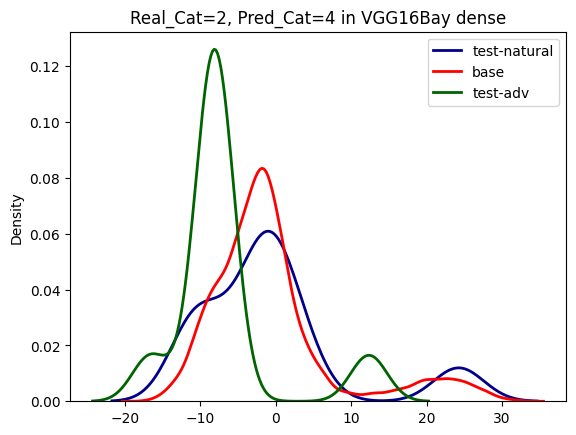

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 63ms/step - loss: 2860.6045 - accuracy: 0.8948


[2860.6044921875, 0.894803524017334]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 66ms/step - loss: 151.7729 - accuracy: 0.9886


[151.77291870117188, 0.9885931611061096]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


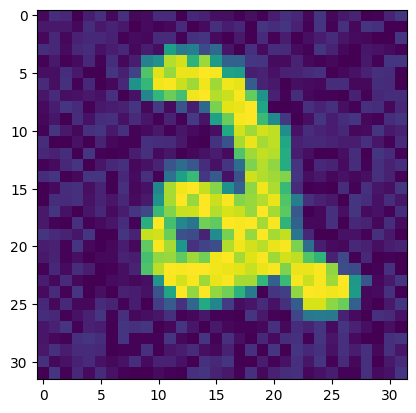

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.219487558369743
distancia energia distribucion base y el ejemplo natural  0.8996355803373962


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.8379446426364632
distancia energia distribucion base y el ejemplo adversario  0.7868975358207766


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1116-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1116-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

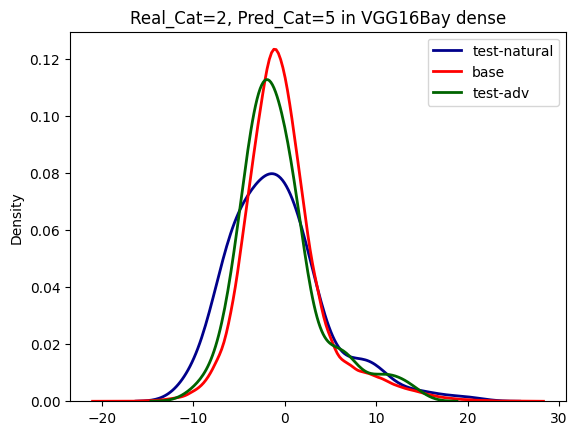

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


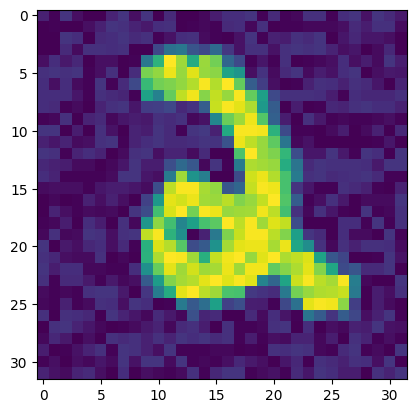

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.6924725870504327
distancia energia distribucion base y el ejemplo natural  0.8895572599737067


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.163472957256003
distancia energia distribucion base y el ejemplo adversario  1.5928776877797624


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1131-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1131-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

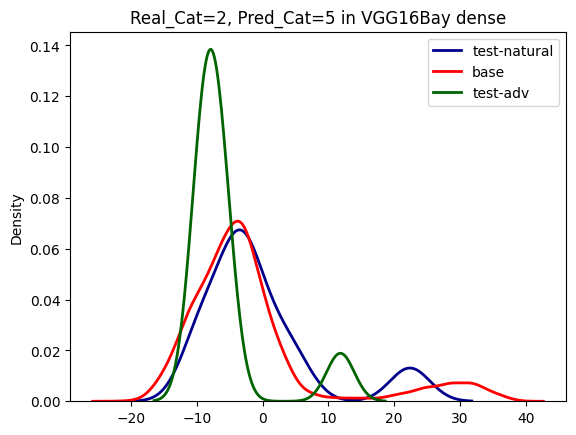

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 75ms/step - loss: 2860.3181 - accuracy: 0.9839


[2860.318115234375, 0.9838895201683044]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 75ms/step - loss: 151.7838 - accuracy: 0.9816


[151.78379821777344, 0.9815880060195923]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


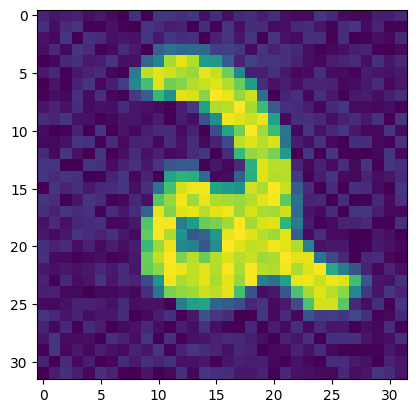

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.250003827140165
distancia energia distribucion base y el ejemplo natural  0.8784231331424192


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.915472820359737
distancia energia distribucion base y el ejemplo adversario  1.0300451563659736


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1150-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1150-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

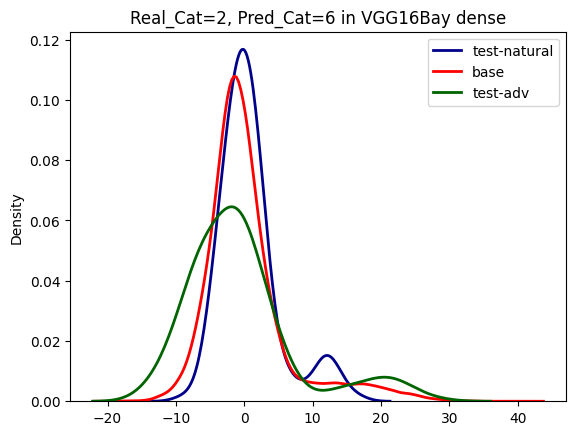

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


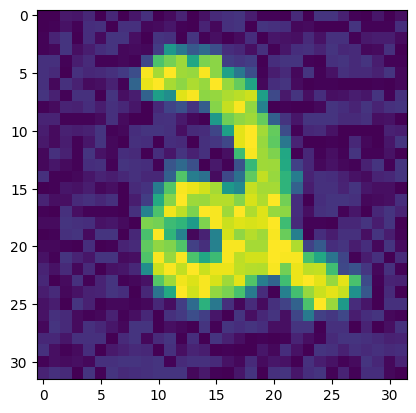

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.518329900771394
distancia energia distribucion base y el ejemplo natural  0.7869875473890705


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.315496590334141
distancia energia distribucion base y el ejemplo adversario  1.62728146140642


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1165-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1165-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

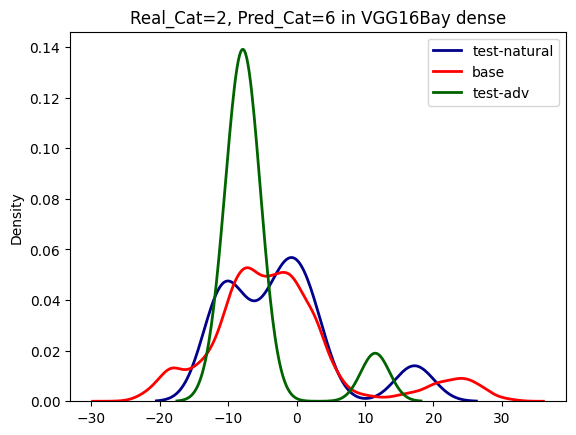

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 74ms/step - loss: 2860.5691 - accuracy: 0.9186


[2860.569091796875, 0.918552041053772]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 75ms/step - loss: 151.8064 - accuracy: 0.9774


[151.80638122558594, 0.9773755669593811]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


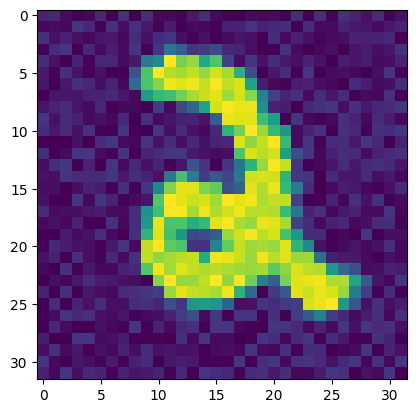

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5723468953050126
distancia energia distribucion base y el ejemplo natural  0.7424589663933217


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.117949352754295
distancia energia distribucion base y el ejemplo adversario  1.056269726274598


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1184-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1184-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

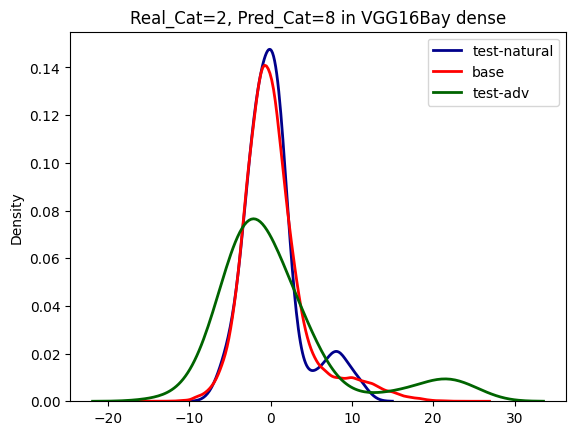

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


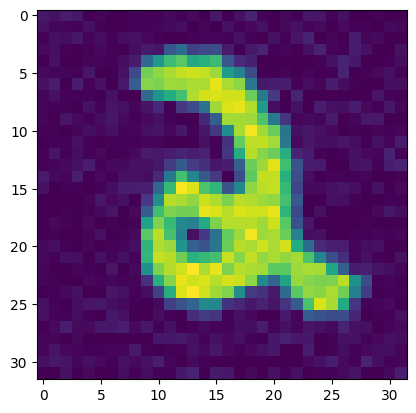

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.319978706971839
distancia energia distribucion base y el ejemplo natural  0.8442337336943515


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.864015617780598
distancia energia distribucion base y el ejemplo adversario  1.1614782383332618


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1199-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1199-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

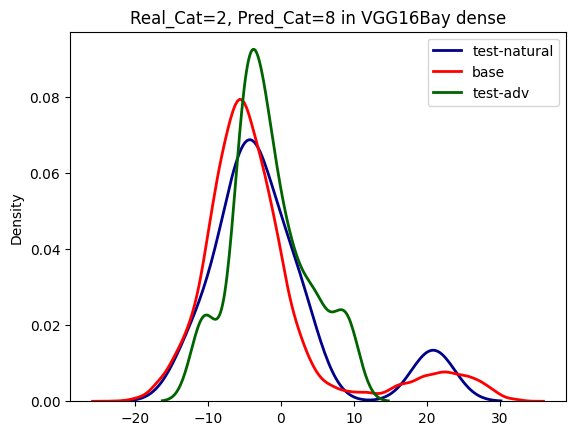

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 59ms/step - loss: 2860.6301 - accuracy: 0.8959


[2860.630126953125, 0.8959025740623474]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 59ms/step - loss: 151.7801 - accuracy: 0.9779


[151.78013610839844, 0.9778516292572021]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist['dense_reparameterization'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


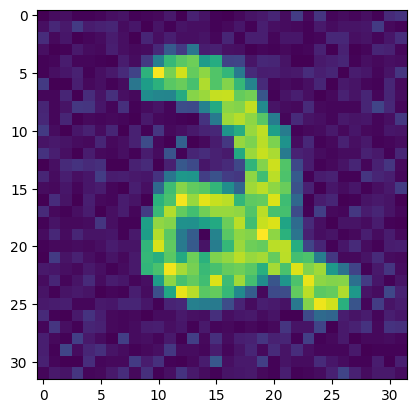

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[6]
[9]
[9]
[9]
[9]
[9]
[7]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist['dense_reparameterization'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6893026393220685
distancia energia distribucion base y el ejemplo natural  0.7783734503256371


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.1296915379026
distancia energia distribucion base y el ejemplo adversario  0.9430770637429523


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1218-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1218-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

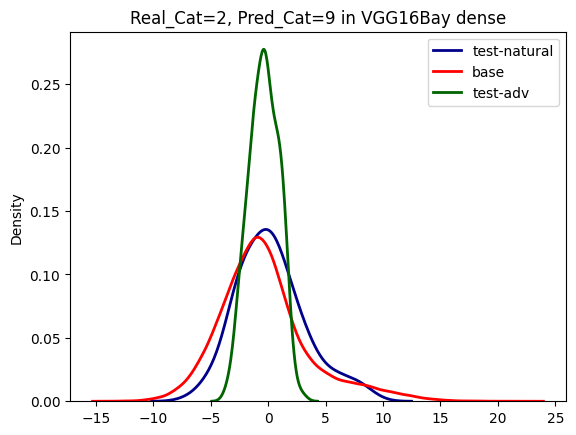

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['dense'](databx)
        valueb_list.append(predictbx)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](dataxtest1)
        valueb_list_test.append(predictx)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


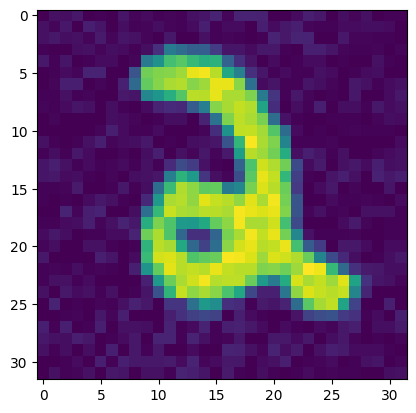

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['dense'](img_adv[None,...])
        valueb_list_testadv.append(predictx)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.6449343217321604
distancia energia distribucion base y el ejemplo natural  0.6575752780241549


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.3071280502962654
distancia energia distribucion base y el ejemplo adversario  0.972759840650001


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-1233-ce3d561ca15c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-1233-ce3d561ca15c>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

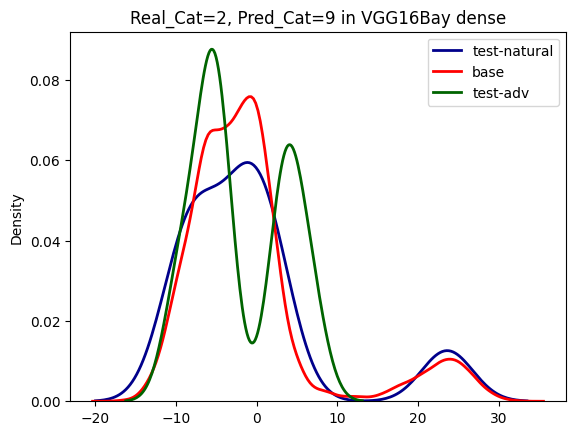

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtFlip',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)